# Inicio

In [1]:
# import os

# os.environ["LOKY_MAX_CPU_COUNT"] = '8'

In [23]:
# Bibliotecas fundamentais
import numpy as np
import pandas as pd

# Bibliotecas gráficas
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

# Data Science
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.inspection import permutation_importance
from sklearn.metrics import ConfusionMatrixDisplay, precision_recall_curve, auc, average_precision_score, classification_report
from sklearn.model_selection import cross_validate, GridSearchCV, StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    MinMaxScaler,
    PowerTransformer,
    RobustScaler,
)
from sklearn.utils import shuffle
import shap


## Imbalanced
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.over_sampling import BorderlineSMOTE, SMOTE
from imblearn.under_sampling import NearMiss, EditedNearestNeighbours

# classificador referência
from sklearn.dummy import DummyClassifier

# estudo lineares
from sklearn.linear_model import LogisticRegression, SGDClassifier


# estudo árvores
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier


# estudo boosting
from sklearn.ensemble import AdaBoostClassifier # perigo dos outliers
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier, plot_importance

# estudo SVM
from sklearn.svm import SVC # Warning: muito lento.

# estudo kNN
from sklearn.neighbors import KNeighborsClassifier

from src.auxiliares import dataframe_coeficientes
from src.config import DADOS_TRATADOS, PASTA_DADOS
from src.graficos import plot_comparar_metricas_modelos, plot_coeficientes
from src.models import RANDOM_STATE
from src.models import (
    grid_search_cv_classificador,
    treinar_e_validar_modelo_classificacao,
    organiza_resultados,
)

sns.set_theme(palette="bright")

In [3]:
df = pd.read_parquet(DADOS_TRATADOS) # vamos considerar a base com mais dados para a primeira avaliação dos modelos

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V19,V20,V21,V23,V24,V26,V27,V28,Amount,Class
0,29003.0,-0.840333,-0.526032,1.730303,-0.808008,-0.202882,-0.076848,0.056146,0.267902,0.525878,...,0.238069,0.237982,0.048635,0.352263,0.062238,0.657536,0.073129,0.186468,110.00,0
1,147097.0,-3.756704,-0.853465,-0.449739,-2.423920,-0.407738,-0.107014,0.123247,0.562870,0.962507,...,-0.452917,-1.561872,0.027063,-0.040820,0.301513,0.373446,-0.862160,0.162344,138.96,0
2,19899.0,1.377495,-0.437941,0.643866,-0.243826,-1.005476,-0.762567,-0.600576,-0.277252,0.776010,...,0.731178,0.050203,-0.161055,-0.036079,0.358121,-0.284928,-0.011904,0.009427,20.00,0
3,71510.0,-0.365864,1.084303,1.232877,0.867853,0.141464,-0.838688,0.747583,-0.101419,-0.492603,...,0.402857,0.141929,0.113073,-0.139327,0.386209,-0.316247,0.412181,0.226690,9.09,0
4,152773.0,-0.190464,1.021640,-0.804140,-0.132867,0.385977,-1.142098,0.469435,0.331246,-0.393996,...,0.003312,-0.241141,0.410755,-0.117616,-0.082971,-0.171760,0.012971,0.041254,14.18,0


## Padronização das colunas

**Observação:** os histogramas do notebook anterior podem ajudar no entendimento. Se for possível colocar os dois notebooks lado a lado, será mais fácil o entendimento.

In [4]:
# Colunas com distribuiçôes pouco definidas merecem um tratamento de escala mais simples
coluna_min_max = [
    "Time"
]

# Colunas com maiores assimetrias e distorções merecem tratamento de normalização mais personalizado 
coluna_power_transformer = [
    "Amount",
]

target = ["Class"]

# Colunas com bastente destaque para outliers mecerem um tratamento mais direcionado a essa característica
colunas_robust_scaler = [
    c for c in df.columns if c not in (coluna_min_max + coluna_power_transformer + target)
]

# Estudo Inicial dos Modelos

## Preparação inicial

In [5]:
X = df.drop(columns=target)
y = df[target].values.ravel()

In [6]:
kf = StratifiedKFold(n_splits=5,
                     shuffle=True,
                     random_state=RANDOM_STATE)

In [7]:
preprocessamento = ColumnTransformer(
    transformers=[
        ("min_max", MinMaxScaler(), coluna_min_max),
        ("standard", RobustScaler(), colunas_robust_scaler),
        ("power_transform", PowerTransformer(), coluna_power_transformer),
    ]
)

## Preparação dos modelos

In [8]:
# Classificadores

scale_pos_weight = np.bincount(y)[0] / np.bincount(y)[1]

classificadores = {

    # Referência

    "DummyClassifier": {
        "preprocessor": None,
        "classificador": DummyClassifier(strategy="stratified"),
        'classe' : "Referência"
    },

    # Lineares
    "LogisticRegression": {
        "preprocessor": preprocessamento,
        "classificador": LogisticRegression(class_weight="balanced"),
               # n_jobs inútil para classificação binária. 

        ## Na classificação binária, o LogisticRegression precisa treinar apenas um classificador.
        ## A otimização (solver) desse classificador é majoritariamente sequencial. 
        ## O n_jobs não consegue distribuir o cálculo de uma única função de custo por todos os núcleos.
        'classe' : "Linear"

    },

    "SGDClassifier": {
        "preprocessor": preprocessamento,
        "classificador": SGDClassifier(random_state=RANDOM_STATE,
                                       loss='perceptron',   
                                       # Alternativa viável para o perceptron em bases maiores 
                                       # e com regularização mais branda (l2)
                                       class_weight='balanced',
                                       n_jobs=-1),
        'classe' : "Linear"
    },


    # Árvore de Decisão

    "DecisionTreeClassifier": {
        "preprocessor": None,
        "classificador": DecisionTreeClassifier(random_state=RANDOM_STATE,
                                                class_weight='balanced'),
        'classe' : "Árvore"
    },

    "ExtraTreesClassifier": {
        "preprocessor": None,
        "classificador": ExtraTreesClassifier(random_state=RANDOM_STATE,
                                                class_weight='balanced',
                                                n_jobs=-1),
        'classe' : "Árvore"
    },

    "RandomForestClassifier": {
        "preprocessor": None,
        "classificador": RandomForestClassifier(random_state=RANDOM_STATE,
                                                class_weight='balanced',
                                                n_jobs=-1),
        'classe' : "Árvore"
        
    },

    # Boosting

    "AdaBoostClassifier": {
        "preprocessor": None,
        "classificador": AdaBoostClassifier(
            estimator=DecisionTreeClassifier(class_weight='balanced'),
            algorithm='SAMME', # apenas para manter o código atualizado para as próximas versões
            random_state=RANDOM_STATE
        ),
        'classe' : "Boosting"

    },

    "LGBMClassifier": {
        "preprocessor": None,
        "classificador": LGBMClassifier(
            random_state=RANDOM_STATE,
            n_jobs=-1,
            verbose=-1,
            scale_pos_weight=scale_pos_weight,
        ),
        'classe' : "Boosting"
    },

    "XGBClassifier": {
        "preprocessor": None,
        "classificador": XGBClassifier(
            random_state=RANDOM_STATE, n_jobs=-1, scale_pos_weight=scale_pos_weight
        ),
        'classe' : "Boosting"
    },


    # Outros

    "SVC": {
        "preprocessor": preprocessamento,
        "classificador": SVC(class_weight="balanced", cache_size=1000),
        'classe' : "Outros"

    },

    "KNeighborsClassifier": {
        "preprocessor": preprocessamento,
        "classificador": KNeighborsClassifier(),
        'classe' : "Outros"
    },
}

In [ ]:
dict_resultados = {}

for modelo, classificador in classificadores.items():

    # criando a pipiline
    pipeline = Pipeline([
        ('preprocessor', classificador['preprocessor']),
        (modelo, classificador['classificador'])
    ])

    # cross validate

    scores = cross_validate(
        estimator=pipeline, 
        X=X, y=y,
        cv=kf,
        scoring=[
            "accuracy",
            "balanced_accuracy",
            "f1",
            "precision",
            "recall",
            "roc_auc",
            "average_precision",
        ],
    )

    dict_resultados[modelo] = scores


In [10]:
df_resultados = pd.DataFrame(dict_resultados).T.reset_index().rename(columns={'index' : 'model'})

df_resultados = df_resultados.explode(column=df_resultados.columns[1:].to_list()).reset_index(drop=True)
df_resultados["time_seconds"] = df_resultados["fit_time"] + df_resultados["score_time"]

mapeamento_categorias = {modelo: info['classe'] for modelo, info in classificadores.items()}
df_resultados['classe'] = df_resultados['model'].map(mapeamento_categorias)

for c in df_resultados.columns[1:-1]:

    df_resultados[c] = pd.to_numeric(df_resultados[c], errors='coerce')

df_resultados.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   model                   55 non-null     object 
 1   fit_time                55 non-null     float64
 2   score_time              55 non-null     float64
 3   test_accuracy           55 non-null     float64
 4   test_balanced_accuracy  55 non-null     float64
 5   test_f1                 55 non-null     float64
 6   test_precision          55 non-null     float64
 7   test_recall             55 non-null     float64
 8   test_roc_auc            55 non-null     float64
 9   test_average_precision  55 non-null     float64
 10  time_seconds            55 non-null     float64
 11  classe                  55 non-null     object 
dtypes: float64(10), object(2)
memory usage: 5.3+ KB


In [11]:
df_resultados.groupby(["model", 'classe']).mean().sort_values(by=["test_average_precision", 'time_seconds'], ascending=[False, True])

,,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,time_seconds
model,classe,,,,,,,,,,
LogisticRegression,Linear,1.020744,0.070869,0.978375,0.952677,0.141528,0.076634,0.926879,0.981899,0.903803,1.091613
ExtraTreesClassifier,Árvore,1.177977,0.126717,0.999693,0.920011,0.912712,1.000000,0.840022,0.962594,0.902115,1.304694
RandomForestClassifier,Árvore,6.548725,0.108698,0.999641,0.906405,0.896171,1.000000,0.812810,0.961276,0.899126,6.657424
XGBClassifier,Boosting,0.650360,0.075068,0.999662,0.922674,0.905201,0.975056,0.845391,0.978893,0.894711,0.725428
SGDClassifier,Linear,0.758025,0.052169,0.978344,0.952643,0.144509,0.078548,0.926842,0.978504,0.889751,0.810194
KNeighborsClassifier,Outros,0.357404,5.404254,0.999636,0.906476,0.895214,0.996923,0.812958,0.932166,0.852429,5.761658
DecisionTreeClassifier,Árvore,5.270936,0.020698,0.999423,0.900919,0.842085,0.888952,0.802036,0.900919,0.712797,5.291634
AdaBoostClassifier,Boosting,4.268895,0.022793,0.999381,0.900898,0.832918,0.869380,0.802036,0.900898,0.697361,4.291688
SVC,Outros,13.061997,12.469080,0.997524,0.847219,0.523431,0.422317,0.696335,0.976065,0.496642,25.531077


In [12]:
print(f'{round(df_resultados['time_seconds'].sum()/60, 1):.1f} minutos totais (treino + teste)')

4.3 minutos totais (treino + teste)


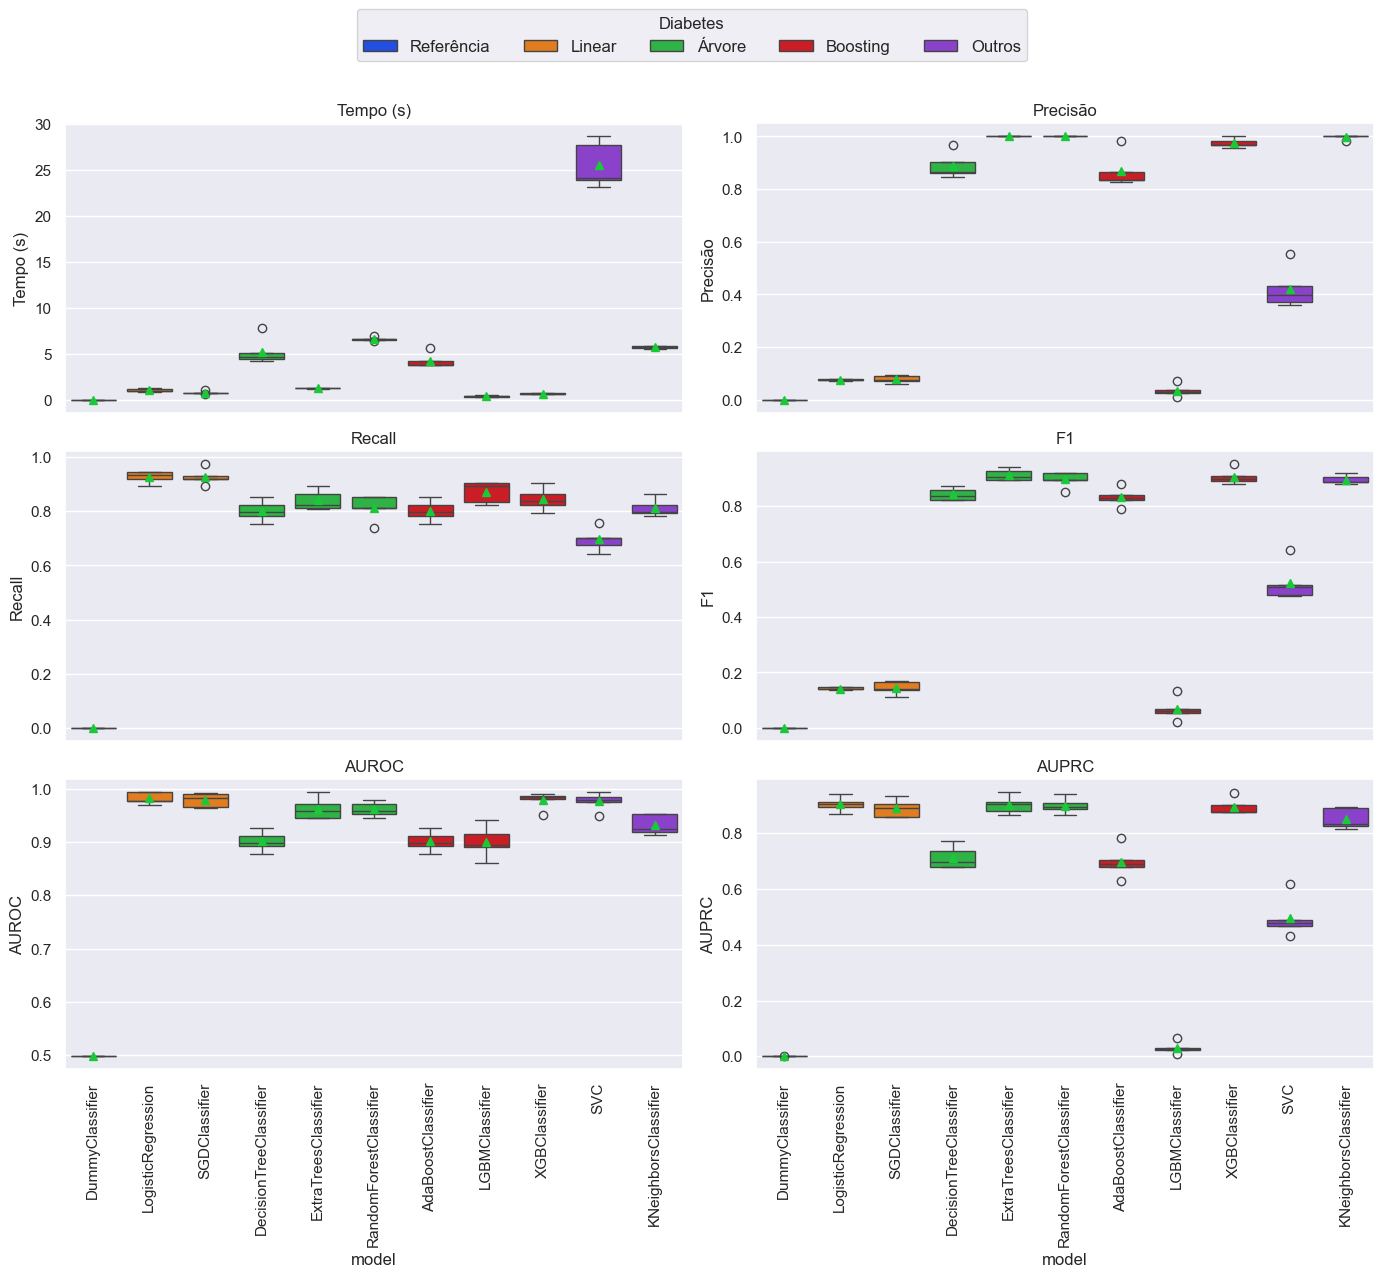

In [13]:
# boxplots
fig, axs = plt.subplots(3, 2, 
                        figsize=(14, 12), 
                        sharex=True)

comparar_metricas = [
        "time_seconds",
        # "test_accuracy",
        # "test_balanced_accuracy",
        "test_precision",
        "test_recall",
        "test_f1",
        "test_roc_auc",
        "test_average_precision",
    ]

nomes_metricas = [
        "Tempo (s)",
        # "Acurácia",
        # "Acurácia balanceada",
        "Precisão",
        "Recall",
        "F1",
        "AUROC",
        "AUPRC",
    ]


for ax, metrica, nome in zip(axs.flatten(), comparar_metricas, nomes_metricas):

    b = sns.boxplot(
        data=df_resultados,
        x='model', y=metrica,
        showmeans=True,
        hue="classe",
        ax=ax,

    )


    legend = b.get_legend()
    legend.remove()


    ax.set_title(nome)
    ax.set_ylabel(nome)
    ax.tick_params(axis='x', rotation=90)

labels = [text.get_text() for text in legend.get_texts()]
fig.legend(handles=legend.legend_handles, labels=labels, loc='upper center', ncols=5, title='Diabetes', bbox_to_anchor=(0.5, 1.07), fontsize=12)

plt.tight_layout()
plt.show()

Visualmente, vários parâmetros são equivalentes. Como nossa base é desbalanceada e parece ser interessante manter um compromisso entre o **Recall e Precisão (F1)**, vamos considerar os modelos com **tempos semelhantes** para avaliar o ``AUPRC`` de forma mais direcionada.

In [14]:
df_resultados['model'].unique()

array(['DummyClassifier', 'LogisticRegression', 'SGDClassifier',
       'DecisionTreeClassifier', 'ExtraTreesClassifier',
       'RandomForestClassifier', 'AdaBoostClassifier', 'LGBMClassifier',
       'XGBClassifier', 'SVC', 'KNeighborsClassifier'], dtype=object)

In [15]:
modelos = list(set(df_resultados['model'].unique()) - {'DummyClassifier', # referência
                                                       'LogisticRegression','SGDClassifier', # F1 baixo
                                                       'DecisionTreeClassifier', # tempo alto
                                                       'LGBMClassifier', # F1 baixo
                                                       'SVC' # Tempo alto
                                                       }) 

df_resultados_f = df_resultados[df_resultados['model'].isin(modelos)]

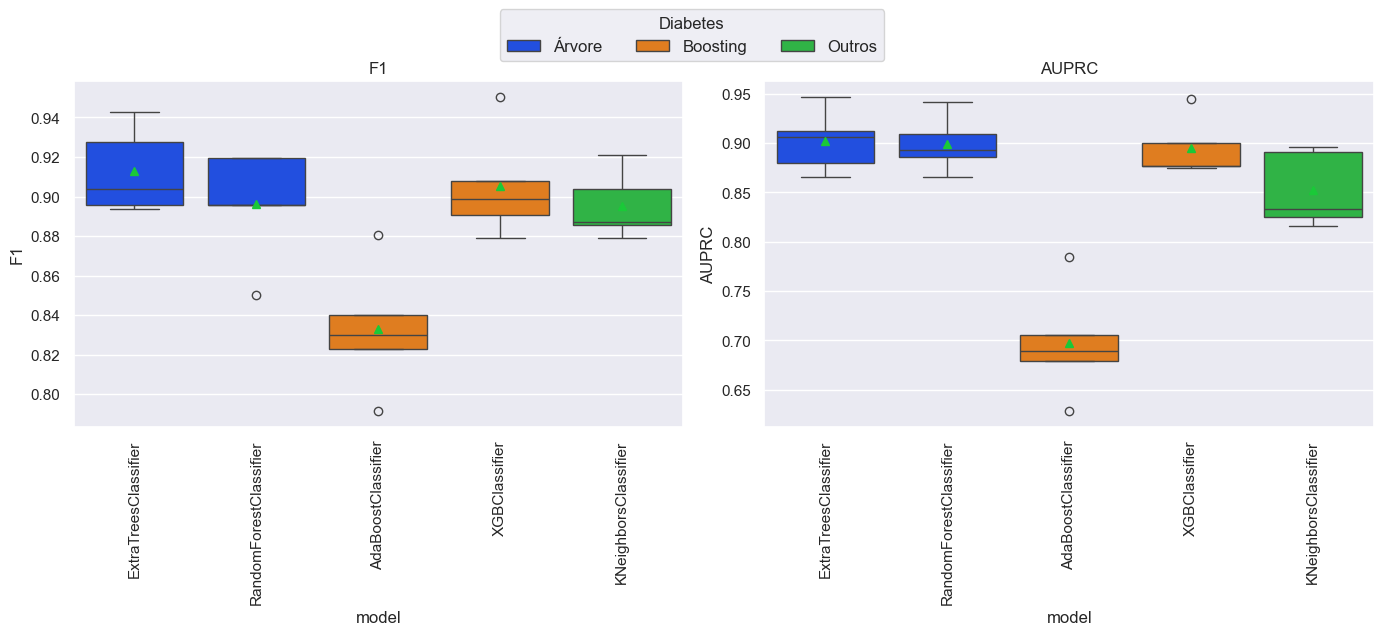

In [16]:
# boxplots
fig, axs = plt.subplots(1, 2, 
                        figsize=(14, 6), 
                        sharex=True)

comparar_metricas = [
        # "time_seconds",
        # "test_accuracy",
        # "test_balanced_accuracy",
        # "test_precision",
        # "test_recall",
        "test_f1",
        # "test_roc_auc",
        "test_average_precision",
    ]

nomes_metricas = [
        # "Tempo (s)",
        # "Acurácia",
        # "Acurácia balanceada",
        # "Precisão",
        # "Recall",
        "F1",
        # "AUROC",
        "AUPRC",
    ]


for ax, metrica, nome in zip(axs.flatten(), comparar_metricas, nomes_metricas):

    b = sns.boxplot(
        data=df_resultados_f,
        x='model', y=metrica,
        showmeans=True,
        hue="classe",
        ax=ax,

    )


    legend = b.get_legend()
    legend.remove()


    ax.set_title(nome)
    ax.set_ylabel(nome)
    ax.tick_params(axis='x', rotation=90)

labels = [text.get_text() for text in legend.get_texts()]
fig.legend(handles=legend.legend_handles, labels=labels, loc='upper center', ncols=5, title='Diabetes', bbox_to_anchor=(0.5, 1.07), fontsize=12)

plt.tight_layout()
plt.show()

Modelos de ``Ensemble`` se sairam muito bem, ``XGBoostig`` e o ``KNN`` no balanço entre **precisão** e **recall**, tal como na nossa principal métrica (para uma base desbalanceada) ``AUPRC``. Vamos olhar os tempos e tomar como métrica adicional para decisão.

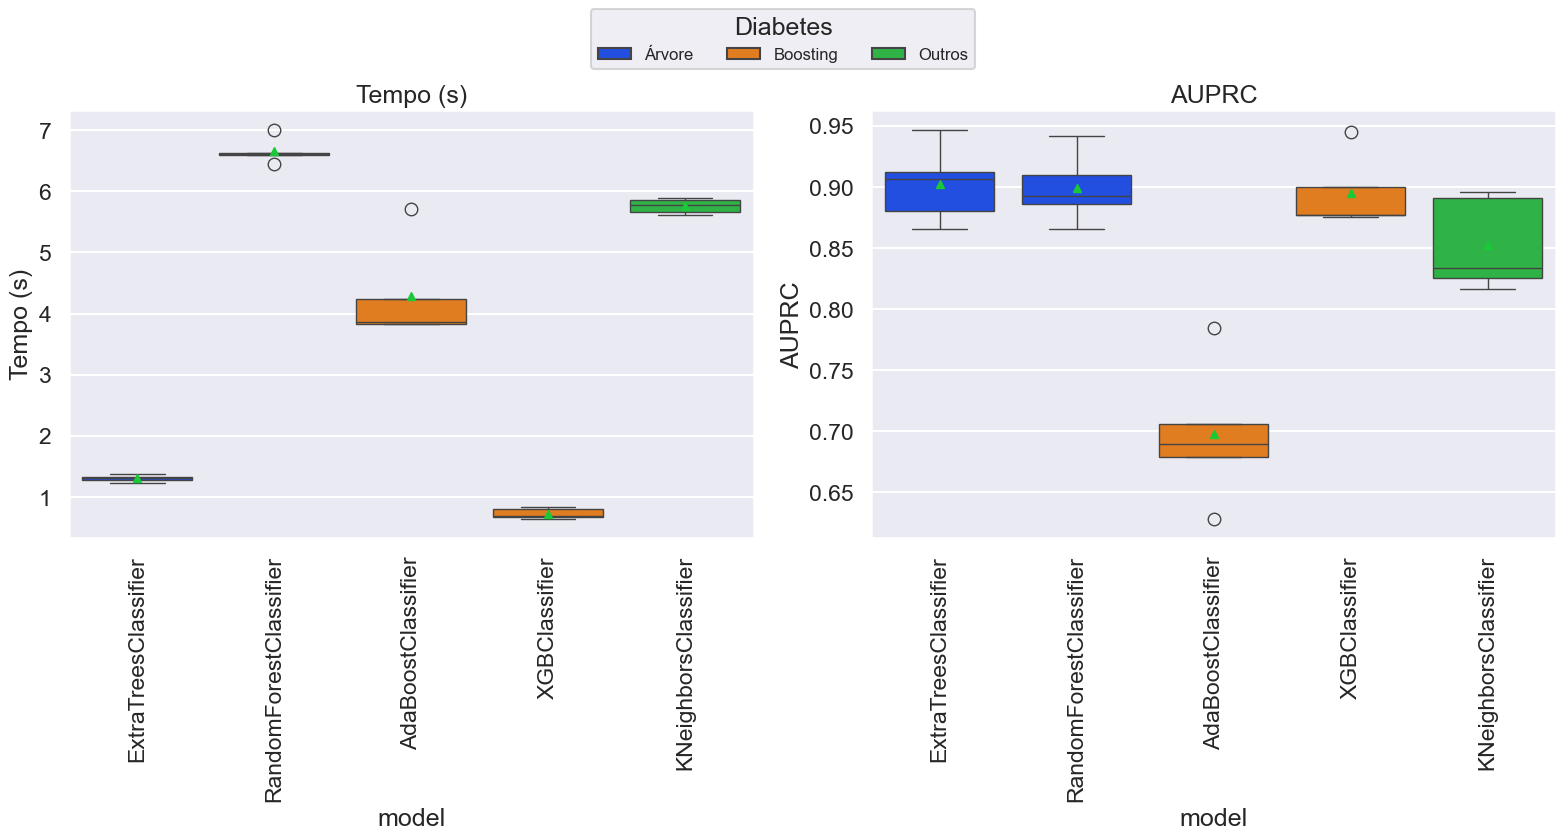

In [17]:
# boxplots
sns.set_context("talk")
fig, axs = plt.subplots(1, 2, 
                        figsize=(16, 8), 
                        sharex=True)

comparar_metricas = [
        "time_seconds",
        "test_average_precision",
    ]

nomes_metricas = [
        "Tempo (s)",
        "AUPRC",
    ]

for ax, metrica, nome in zip(axs.flatten(), comparar_metricas, nomes_metricas):

    b = sns.boxplot(
        data=df_resultados_f,
        x='model', y=metrica,
        showmeans=True,
        hue="classe",
        ax=ax,
    )


    legend = b.get_legend()
    legend.remove()


    ax.set_title(nome)
    ax.set_ylabel(nome)
    ax.tick_params(axis='x', rotation=90)


labels = [text.get_text() for text in legend.get_texts()]
fig.legend(handles=legend.legend_handles, labels=labels, loc='upper center', ncols=5, title='Diabetes', bbox_to_anchor=(0.5, 1.07), fontsize=12)

plt.tight_layout()
plt.show()

### Discussão inicial

1. Para bases grandes, o modelo `SVC` requer mais recurso computacional e exige um _tunning_ mais refinado. Isso acontece devido a sua natureza multidimensional e cálculos mais sofisticados para convergência (o `SVC` escala de forma quadrática ou até cúbica em relação ao número de amostras). 

    Entanto, já se mostrou bem inferior a modelos mais performáticos na forma padrão, logo, demandar esforço e apreço à otimização pode exigir recursos que seriam melhor aproveitados com modelos mais promissores.

2. `AdaBoost` é prejuticado em bases com muitos _outliers_, devido a sua natureza de otimização (por pesos). Ele tende a "corrigir" erros de forma _Leve-wise_, ou seja, nível por nível dando maior peso aos erros do modelo anterior. Esse "foco obssesivo em pessos" acaba **privilegiando erros por _outliers_** que deveriam ser negligenciados. Podemos dizer que ele é "sequestrado" por _outliers_. 

    Isso é bem corrigido pelo modelo `XGBoost`, por exemplo, pois ele tende a mínimizar os erros de forma mais sofisticada (gradiente de derivada) e menos rígida ao invés de forma bruta (pesos, no `AdaBoost`) e permite regularização (l2 como padrão) que deixa os pesos das folhas mais suaves. 

3. Nesse contexto, vemos que o `LGBMClassifier` obteve uma _performance_ bem inferior aos demais de `Boosting`. Talvez o mecanismo de otimização _leaf-wise_ (folha por folha) seja prejudicado nessa combinação de _outliers_ e desbalanceamento severo. ``LGBM`` é eficiente em velocidade, mas em datasets menores OU com desbalanceamento extremo (nosso caso), ele pode convergir muito rápido para um mínimo local, perdendo generalização se os hiperparâmetros (como ``num_leaves`` ou ``min_data_in_leaf``) não estiverem muito bem ajustados.

4. Os modelos de árvoe do tipo `Ensemble` e o `XGBoost` pareceram bem promissores. Os modelos de árvore, em especial `Ensemble`, são pouco ou nada sesíveis a _outliers_, o que é intrínseco a sua natureza de booleana (verdadeiro ou falso) das árvores; o `XGBoost` usa desse benefício de forma otimizada com grandes volumes de dados. Isso promove essa maior estabilização do tempo exigido, como visto acima, e resultados bem equivalentes.

5. Os modelos `Ensemble` se mostraram em outra ordem de grandeza quanto ao tempo, em especial o `RandomForest`. Talvez a naturza aleatória do `ExtraTrees` ajude na escolha de divisões (_splits_) das árvores, ao invés de procurar o "melhor ponto" de forma exaustiva, como o `RandomForest` faz.

6. A disparidade que você observa entre o AUPRC (que está próximo de 0.90) e o F1/Precisão no ``LogisticRegression`` é um sintoma clássico de como diferentes métricas interpretam o desbalanço de classes. As métricas **F1 e Precisão são calculadas com base em um limiar fixo**, no nosso caso 0.5. Em uma base com ``0,19%`` de fraudes, a Regressão Logística tende a atribuir probabilidades muito baixas para quase todos os registros, _e.g._ 0.01, 0.05. Como nenhuma transação ultrapassa o "muro" de 0.5, o modelo acaba classificando quase tudo como "Não Fraude". ``Isso destrói a Precisão e o F1``, pois os poucos acertos são diluídos por muitos ``Falsos Negativos``.


    Considerar o ``AUPRC`` de forma isolada é um pouco perigoso, porque ele é uma métrica muito mais "generosa". Ela **não depende de um único limiar**, pois testa todos os limiares possíveis (de 0.0 a 1.0) e resume a performance em um único número. Um AUPRC de ``~0.90`` significa que, embora o modelo esteja dando probabilidades baixas, as transações que são realmente fraude estão no topo da lista. Ou seja, se você ordenar sua base pelas probabilidades da Regressão Logística, as fraudes estarão quase todas agrupadas no topo, mesmo que a probabilidade delas seja de apenas 0.19%.

- Principais conclusões:

1. O Modelo SVC, como esperado para bases grandes, levou um tempo muito maior que o esperado para os demais, sem entregar uma _performance_ de destaque. Deve ser prontamente descartado (primeiro gráfico).<br>

2. ``AdaBoost`` é sequestrado por _outliers_.
3. ``LGBM`` pode ficar preso em mínimos locais do que os demais, apesar da velocidade e _performance_ otimizada pelo conceito de _Boosting_.
4. Os modelos de árvoe do tipo `Ensemble` e o `XGBoost` pareceram bem promissores. 
5. Com o segundo gráfico, ficou mais claro que o modelo `XGBoost` é o mais rápido dentre os mais performáticos, como se esperava, e será o de escolha para seguirmos.
6. Modelos lineares tendem a performar mal em bases desbalanceadas.

**Observação:** se tratando da proximidade (poucos segundos) entre o `ExtraTress` e o `XGBosst` é compreensível a escolha alternativa, se assim for o desejo. Entretanto, proporcionalmente, o `XGBoost` leva metade do tempo para fit e previsão. Inclusive, realizei um teste de otimização com ambos modelos e o `ExtraTress` obteve algo ao redor de 3x o tempo de treino do `XGBosst`, logo, em escala, esses "poucos décimos" de diferença são relevantes!

### Influência da base

Agora que já entendemos de uma forma geral os comportamentos esperados para os modelos, podemos validar a influência da base nas principais métricas usando o nosso modelo de escolha como referência, mas é algo que se compartilha com os demais (testei em um outro notebook, mas convido o leitor a essa experimentação):

In [18]:
arquivos_treino = list(PASTA_DADOS.glob("creditcard_train*.parquet"))
arquivos_treino.append(DADOS_TRATADOS)

In [19]:
todos_os_resultados = []

classificador_escolhido = 'XGBClassifier'

for caminho_df in arquivos_treino:

    # 1. Importação e identificação do cenário
    cenario = caminho_df.stem.replace("creditcard_", "") 
    df = pd.read_parquet(caminho_df)

    X = df.drop(columns=target)
    y = df[target].values.ravel()

    # 2. Ajuste dinâmico de proporção
    spw = np.bincount(y)[0] / np.bincount(y)[1]

    # 3. Resgata o modelo e atualiza apenas o parâmetro necessário
    modelo_base = classificadores[classificador_escolhido]['classificador']
    modelo_base.set_params(scale_pos_weight=spw)

    # 4. Definição do Pipeline usando as configurações do dicionário
    pipeline = Pipeline([
        ('preprocessor', classificadores[classificador_escolhido]['preprocessor']), 
        (classificador_escolhido, modelo_base)
    ])

    # 5. Cross-validation
    scores = cross_validate(
        estimator=pipeline, 
        X=X, y=y, 
        cv=kf,
        scoring=["f1", "average_precision"]
    )


    # 5. Organização dos resultados
    df_temp = pd.DataFrame(scores)
    df_temp['model'] = 'XGBClassifier'
    df_temp['cenario'] = cenario
    df_temp['time_total'] = df_temp['fit_time'] + df_temp['score_time']
    
    todos_os_resultados.append(df_temp)

# 6. Consolidação e Relatório Final
df_final_comparativo = pd.concat(todos_os_resultados, ignore_index=True)

relatorio = df_final_comparativo.groupby(['cenario', 'model']).mean(numeric_only=True).sort_values(
    by=['test_average_precision'], ascending=False
)

relatorio.style.format('{:.2f}')

,,fit_time,score_time,test_f1,test_average_precision,time_total
cenario,model,,,,,
train_limpo_0.3,XGBClassifier,0.49,0.04,0.93,0.93,0.53
train_limpo_0.2,XGBClassifier,0.62,0.04,0.93,0.92,0.66
crediticard_mult_var_treino,XGBClassifier,0.65,0.04,0.91,0.89,0.69
train_limpo_0.05,XGBClassifier,0.75,0.05,0.90,0.88,0.80
train_limpo_0.01,XGBClassifier,0.76,0.05,0.89,0.87,0.80


In [20]:
print(f'{round(df_final_comparativo['time_total'].sum(), 1):.1f} segundos totais (treino + teste)')

17.4 segundos totais (treino + teste)


É interessante notar que esse aumento na performance pode ser causado pelo _overfitting_ aos dados. Temos uma proporção de desbalanço menor em cada Data Frame, mas o mais relevante é o menor número de registros. E essa tendência de desbalanceamento crescente e menor número de registros acompanha o aumento da métrica de sucesso.

Vamos validar o _overfitting_ com nossos dados de teste reservados:

In [21]:
df_teste_reservado = pd.read_parquet(PASTA_DADOS / 'creditcard_TESTE_RESERVADO.parquet')

X_test_real = df_teste_reservado.drop('Class', axis=1)
y_test_real = df_teste_reservado['Class']

In [22]:
resultados_overfitting = []

for caminho_df in arquivos_treino:

    # Importação e identificação do cenário
    cenario = caminho_df.stem.replace("creditcard_", "") 
    df = pd.read_parquet(caminho_df)
    
    # Preparação dos dados de treino
    X_train_limpo = df.drop('Class', axis=1)
    y_train_limpo = df['Class']

    spw = np.bincount(y_train_limpo)[0] / np.bincount(y_train_limpo)[1]

    # Treinamento do modelo
    model_xgb = classificadores[classificador_escolhido]['classificador']
    model_xgb.set_params(scale_pos_weight=spw)
    model_xgb.fit(X_train_limpo, y_train_limpo)
    
    # Avaliação no Teste Reservado (Cofre - Dados Reais)
    y_probs_cofre = model_xgb.predict_proba(X_test_real)[:, 1]
    auprc_cofre = average_precision_score(y_test_real, y_probs_cofre)
  
    auprc_validacao_limpa = relatorio.loc[cenario, classificador_escolhido]['test_average_precision']


    # Cálculo da Queda de Performance
    queda_performance = (auprc_validacao_limpa - auprc_cofre) / auprc_validacao_limpa
    
    # Armazena os resultados no dicionário
    resultados_overfitting.append({
        'Cenário': cenario,
        'AUPRC_Validação_Limpa': round(auprc_validacao_limpa, 4),
        'AUPRC_Cofre_Real': round(auprc_cofre, 4),
        'Queda_Performance': queda_performance,
        'Status': "Overfitting" if queda_performance > 0.15 else "Generalizou"
    })

# Cria o DataFrame final
df_overfitting = pd.DataFrame(resultados_overfitting)

df_final = df_overfitting.sort_values(by='Queda_Performance').reset_index(drop=True)

df_estilizado = df_final.style.format({
    'AUPRC_Validação_Limpa': '{:.2f}',
    'AUPRC_Cofre_Real': '{:.2f}',
    'Queda_Performance': '{:.2%}'
})

df_estilizado

,Cenário,AUPRC_Validação_Limpa,AUPRC_Cofre_Real,Queda_Performance,Status
0,train_limpo_0.01,0.87,0.74,14.72%,Generalizou
1,train_limpo_0.2,0.92,0.72,21.30%,Overfitting
2,train_limpo_0.05,0.88,0.69,21.52%,Overfitting
3,crediticard_mult_var_treino,0.89,0.68,23.51%,Overfitting
4,train_limpo_0.3,0.93,0.68,26.88%,Overfitting


**- Conclusões**

1. Nota-se claramente um viés de _overfitting_ nas novas bases testadas. Em geral, o sinal de melhora significativa para todos é um alerta importante. Devo dizer que até o tempo de total ser tão pequeno pode ser um reforçador nesse sentido. Um viés oculto também está nos poucos registros, o que pode significar **que qualquer erro de amostragem** no cross-validation causarão uma ``oscilação enorme`` na confiança do modelo.


2. No notebook anterior vimos certa perda do ``desbalanço real`` (porporção entre normais e fraude). Essa ``descaracterização`` sutil pode ter **simplificado demais as bases** demais, de forma que nossos modelos tiveram grande facilidade em encontrar os **"padrões"**, neste caso, **pouco aderentes com a realidade**. Há o que se dizer, no mesmo sentido de _overfitting_, por óbivo, sobre o **perigo da falta de generalização**. No último cenário isso ainda é mais agravado devido falta de quase metade registros na base.

### Sobre amostragem

Alguém poderia dizer que em um desbalanço valeria a pena observar uma abordagem de _sampling_ como o _UnderSampling_ ou o _OverSampling_, entretanto, acredito que em um desbalanço tão severo e uma base tão grande, a retirada de dados aleatória (_UnderSampling_) poderia ser bem prejudicial, tal como a população até a igualdade (_OverSampling_). 

Com o indício de que a proporção entre as bases parece ser importante para evitaro _overfitting_, principalmente, o volume de registros da classe majoritária. Nesse sentido, manipular a base pode trazer resultados melhores, como os vistos acima, porém **levar a uma descaracterização prejudicial ao modelo.**

Há o que se dizer em que, bem ou mal, para um modelo de árvore já encotramos um "divisor de àguas", como o `V14` e `V4`. O alto ganho da `V14` indica que a distribuição dessa variável para a classe minoritária (fraude) é significativamente diferente da classe majoritária. **Se o sinal é forte, o desbalanceamento torna-se um problema secundário, pois a "fronteira de decisão" é nítida**

Entretanto, acredito ser pertinente o teste de **abordagens balanceadas**, justamente pare evitar o _overfitting_ certo que nos esperaria no caso de desmantelação da classe majoritária ou superpopulação artificial da classe minoritária, pode ser interessante para discussão.

**- Técnicas Usadas:**

``SMOTETomek:`` Ele cria amostras sintéticas (``SMOTE``) e depois remove os **Tomek Links** (pares de pontos de classes diferentes que são vizinhos mais próximos). É a técnica **menos agressiva**. Ela tende a manter a **Precisão alta**, pois remove apenas os casos de maior ambiguidade, transações que estão no limiar do _threshold_ (será uma discussão mais a frente).

``SMOTEENN:`` Ideal para cenários onde a fraude e o comportamento legítimo se confundem muito. O ``ENN`` (Edited Nearest Neighbors) é muito **mais rigoroso** que o ``Tomek``. Ele remove qualquer ponto que não concorde com a **maioria dos seus vizinhos**.

``SMOTE_NearMiss:`` O ``SMOTE`` aumenta as fraudes, e o ``NearMiss`` **deleta todas as transações normais "fáceis"** (longe da fronteira), mantendo apenas próximas das fraudes. Pode ser perigoso para _overfitting_, mas pode criar um modelo extremamente "especialista" em distinguir casos no _threshold_.

``Borderline_ENN:``O ``BorderlineSMOTE`` primeiro classifica os pontos da classe minoritária em **seguros** (fáceis), **perigosos** (na borda) ou **ruído**. Ele gera novos dados apenas para os pontos ``perigosos``. O ``ENN`` entra depois para garantir que nenhuma dessas novas amostras tenha invadido demais o "espaço alheio".

In [45]:
# Recuperando a base mais confiável
df = pd.read_parquet(PASTA_DADOS / f'creditcard_{df_overfitting.loc[df_overfitting['Queda_Performance'].idxmin() ,'Cenário']}.parquet') # cenário com menos overfiiting, mesmo que com métricas piores.

X = df.drop(columns=target)
y = df[target].values.ravel()

In [46]:
X_train_limpo, X_test_limpo, y_train_limpo, y_test_limpo = train_test_split(X, y,
                                                                            test_size=0.2,
                                                                            random_state=RANDOM_STATE,
                                                                            stratify=y)

In [47]:
estrategias_combinadas = {
    'SMOTETomek': SMOTETomek(random_state=42),

    'SMOTEENN': SMOTEENN(random_state=42),

    'SMOTE_NearMiss': ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('nearmiss', NearMiss(version=1))
    ]),
    
    'Borderline_ENN': ImbPipeline([
        ('borderline', BorderlineSMOTE(random_state=42)),
        ('enn', EditedNearestNeighbours())
    ])
}

In [92]:

resultados_pipeline = []

for nome_tecnica, transformador in estrategias_combinadas.items():
    
   
# Criamos a lista de passos básica
    passos = []
    
    # Se for uma sub-pipeline (como SMOTE + NearMiss)
    if isinstance(transformador, ImbPipeline):
        passos.extend(transformador.steps)
        
    else:
        passos.append(('balanceamento', transformador))
    

    passos.append(('classifier', classificadores[classificador_escolhido]['classificador']))
    pipeline = ImbPipeline(steps=passos)
    pipeline.named_steps['classifier'].set_params(scale_pos_weight=1) 
    
    pipeline.fit(X_train_limpo, y_train_limpo)

    y_probs_cofre = pipeline.predict_proba(X_test_real)[:, 1]
    
    auprc_cofre = average_precision_score(y_test_real, y_probs_cofre)
    
    auprc_ref = auprc_validacao_limpa 
    queda = (auprc_ref - auprc_cofre) / auprc_ref

    resultados_pipeline.append({
        'Técnica': nome_tecnica,
        'AUPRC_Ref_Original': round(auprc_ref, 4),
        'AUPRC_Cofre_Técnica': round(auprc_cofre, 4),
        'Queda_Performance': queda,
        'Status': "Overfitting" if queda > 0.15 else "Generalizou"
    })


df_resumo_tecnicas = pd.DataFrame(resultados_pipeline).sort_values(by='AUPRC_Cofre_Técnica', ascending=False)
df_resumo_tecnicas.style.format({
    'AUPRC_Ref_Original': '{:.2%}',
    'AUPRC_Cofre_Técnica': '{:.2%}',
    'Queda_Performance': '{:.2%}'
    })

,Técnica,AUPRC_Ref_Original,AUPRC_Cofre_Técnica,Queda_Performance,Status
2,SMOTE_NearMiss,89.47%,70.00%,21.76%,Overfitting
0,SMOTETomek,89.47%,69.49%,22.34%,Overfitting
1,SMOTEENN,89.47%,69.48%,22.35%,Overfitting
3,Borderline_ENN,89.47%,66.96%,25.16%,Overfitting


**- Discussão**

``SMOTE_NearMiss`` se esperava ser o mais robusto e ``Borderline_ENN`` pouco aderente a nossa base com perfil de muitos _outliers_.

``SMOTETomek`` e ``SMOTEENN`` focam em limpar a fronteira entre as classes. O fato de terem resultados quase idênticos sugere que o "ruído" que elas removeram não era o principal problema da base, mas sim a falta de generalização dos dados sintéticos criados pelo ``SMOTE``.

# Estudo do modelo mais promissor

No primeiro notebook fizemos uma avaliação das _features_ que pouco ou nada discriminariam o target, chamamamos isso de ``"relação significativa"``. Entretanto, com o melhor modelo escolhido, `XGBClassifier`, pode ser pertinente avaliar se, para esse em particular, **todas as features parecem ter impacto significativo** na discriminação entre as classes. Isso pode resultar em um ganho de tempo útil antes da etapa de otimização dos hiperparâmetros, principalemente, porque este modelo permite uma infinidade deles.

In [50]:
# Criar um separação para teste

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=RANDOM_STATE,
                                                    stratify=y)

scale_pos_weight = np.bincount(y_train)[0] / np.bincount(y_train)[1]

# Definir e treinar o modelo
modelo_de_escolha = 'XGBClassifier'

clf_base = XGBClassifier(
            random_state=RANDOM_STATE,
            n_jobs=-1, 
            scale_pos_weight=scale_pos_weight
            )

clf = Pipeline([
    ('preprocessor', classificadores[modelo_de_escolha]['preprocessor']),
    ('clf', clf_base)
])


clf.fit(X_train, y_train)


# Avaliar a relevância das features
perm_imp = permutation_importance(
    clf,
    X_test, y_test,
    n_repeats=10, 
    random_state=RANDOM_STATE,
    n_jobs=-1,
    scoring='average_precision'
)

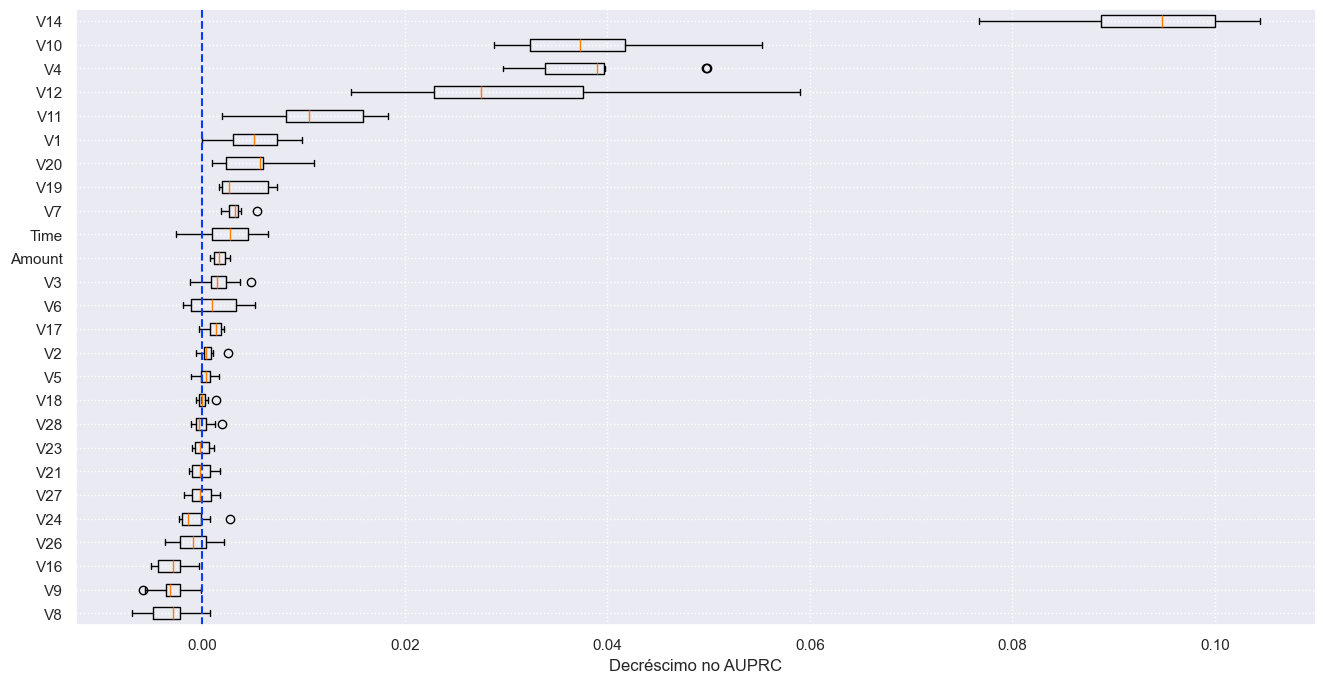

In [51]:
# Criação do gráfico

ordem = perm_imp.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(16, 8))

ax.boxplot(
    perm_imp.importances[ordem].T, 
    vert=False, 
    tick_labels=X.columns[ordem]
           )


ax.axvline(x=0, linestyle="--")

ax.set_xlabel(f"Decréscimo no AUPRC")

ax.grid(True, linestyle=":")

plt.show()

Fica claro que é possível selecionar algum critério para excluir features irrelevantes (baseada nesse critério), veja:

In [52]:
# Preparar os dados (ordenar do maior para o menor impacto)
importancias_medias = perm_imp.importances_mean
indices_ordenados = importancias_medias.argsort()[::-1]
nomes_ordenados = X.columns[indices_ordenados]
valores_ordenados = importancias_medias[indices_ordenados]

# Calcular a importância acumulada e relativa e normalizar
importancia_acumulada = np.cumsum(valores_ordenados)
importancia_relativa_acumulada = importancia_acumulada / importancia_acumulada[-1]

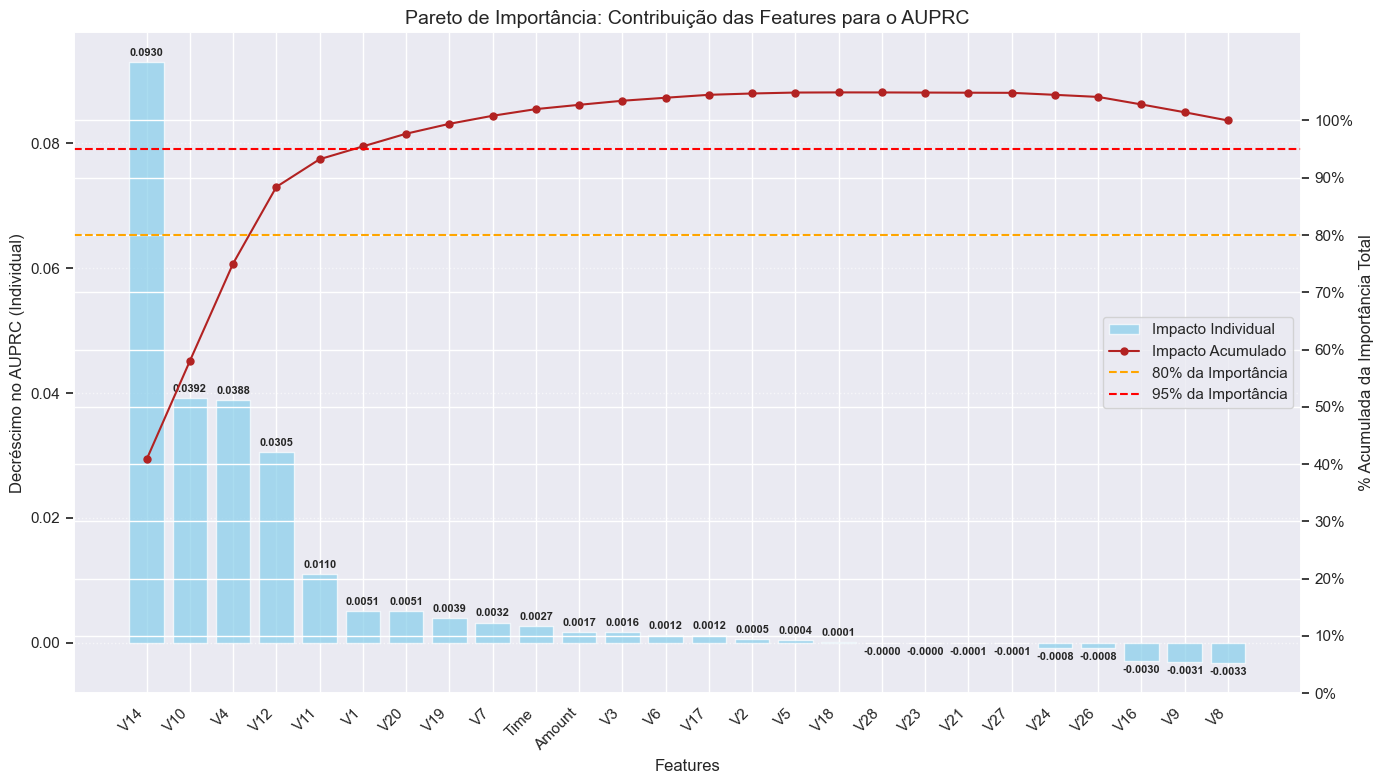

In [53]:
# Criar o Gráfico de Pareto
fig, ax1 = plt.subplots(figsize=(14, 8))

b = ax1.bar(
    nomes_ordenados, 
    valores_ordenados, 
    color="skyblue", 
    alpha=0.7, 
    label="Impacto Individual"
    )

ax1.set_ylabel("Decréscimo no AUPRC (Individual)", fontsize=12)
ax1.set_xlabel("Features", fontsize=12)
plt.xticks(rotation=45, 
           ha='right')

ax1.bar_label(b, 
              padding=3, 
              fmt='%.4f', fontsize=8, fontweight='bold')

ax2 = ax1.twinx()
ax2.plot(
    nomes_ordenados,
    importancia_relativa_acumulada, 
    color="firebrick", marker="o", ms=5, 
    label="Impacto Acumulado"
    )
ax2.set_ylabel("% Acumulada da Importância Total", fontsize=12)
ax2.set_ylim(0, importancia_relativa_acumulada.max() * 1.1)


ax2.axhline(y=0.8, color='orange', linestyle='--', label="80% da Importância")
ax2.axhline(y=0.95, color='red', linestyle='--', label="95% da Importância")


ax1.set_title("Pareto de Importância: Contribuição das Features para o AUPRC", 
              fontsize=14)
ax1.set_xticks(range(len(nomes_ordenados)))
ax1.set_xticklabels(nomes_ordenados)
ax2.set_yticks(np.arange(0, 1.1, 0.1))

posicoes = np.arange(0, 1.1, 0.1)
labels_percent = [f'{int(x*100)}%' for x in posicoes]

ax2.set_yticks(posicoes)
ax2.set_yticklabels(labels_percent)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0)) 


lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, 
           loc="center right")

ax1.grid(axis='y',
          linestyle=":", 
          alpha=0.6)

plt.tight_layout()
plt.show()

**- Observação sobre as ténicas de balanceamento aplicadas acima:**

As técnicas de ``SMOTE`` criam fraudes artificiais através de **interpolação linear** (geometria euclidiana). Em bases onde variáveis como ``V14`` são muito dominantes e possuem bastante _outlier, o algoritmo acaba criando fraudes em espaços geométricos que nunca seriam fraudes na vida real. 

Na base a variável ``V14`` é um indicador crítico (ex: valores muito baixos indicam fraude, como veremos no gráfico de ``SHAP`` values), o ``SMOTE`` pode criar um ponto sintético **ligando duas fraudes reais**. No entanto, se entre essas duas fraudes houver um "buraco" onde **apenas transações legítimas existem** na vida real, o ``SMOTE`` criará uma **fraude artificial** exatamente ali.

O modelo aprende a "geometria do SMOTE" em vez da "lógica da fraude".

In [54]:
for p, i in enumerate(valores_ordenados):
    if i <  0.001:
        coluna = nomes_ordenados[p]
        valor = round(valores_ordenados[p],4)
        break
    else:
        continue

print(f"Com o gráfico fica fácil de ver que qualquer número acima de {valor}, ou seja, a coluna {coluna}, já contribui significativamente para o modelo!")

Com o gráfico fica fácil de ver que qualquer número acima de 0.0005, ou seja, a coluna V2, já contribui significativamente para o modelo!


**Obs.:** o acumulado ser >100% é esperado, pois somente no final (ao somar todas as colunas) o valor deve ser 100% (vide importâncias negativas à direita).

In [55]:
criterio = valor
colunas_filtradas = X.columns[perm_imp.importances_mean < criterio]

colunas_criterio = len(X.columns) - len(colunas_filtradas)

print(f'colunas de acordo com o critério: {colunas_criterio}', '\n' 
      f'total de colunas: {len(X.columns)}')

colunas de acordo com o critério: 15 
total de colunas: 26


In [56]:
X = X.drop(columns=colunas_filtradas)
X.shape

(211472, 15)

Vamos validar o modelo com apenas as colunas relevantes:

In [57]:
# Dicionário de resultados
dict_melhor_modelo = {}

# criando a pipiline
pipeline = Pipeline([
    ('preprocessor', classificadores[modelo_de_escolha]['preprocessor']),
    ('clf', clf_base)
])

# cross validate

scores = cross_validate(
    estimator=pipeline, 
    X=X, y=y,
    cv=kf,
    scoring=[
        "accuracy",
        "balanced_accuracy",
        "f1",
        "precision",
        "recall",
        "roc_auc",
        "average_precision",
    ],
)

dict_melhor_modelo['XGBClassifier'] = scores
dict_melhor_modelo['XGBClassifier']


{'fit_time': array([0.46855474, 0.4651835 , 0.46106553, 0.44390368, 0.45558524]),
 'score_time': array([0.07471132, 0.06668401, 0.05755973, 0.06728721, 0.06104183]),
 'test_accuracy': array([0.99957442, 0.99964535, 0.9997872 , 0.99952712, 0.99964534]),
 'test_balanced_accuracy': array([0.89861312, 0.92562831, 0.95886858, 0.88509961, 0.91888339]),
 'test_f1': array([0.86764706, 0.89361702, 0.93706294, 0.85074627, 0.89208633]),
 'test_precision': array([0.9516129 , 0.94029851, 0.95714286, 0.95      , 0.95384615]),
 'test_recall': array([0.7972973 , 0.85135135, 0.91780822, 0.77027027, 0.83783784]),
 'test_roc_auc': array([0.98937636, 0.97269404, 0.99621269, 0.95931927, 0.95125725]),
 'test_average_precision': array([0.8318449 , 0.89493789, 0.93291972, 0.79871267, 0.85895966])}

In [58]:
df_resultados_melhor = pd.DataFrame(dict_melhor_modelo).T.reset_index().rename(columns={'index' : 'model'})

df_resultados_melhor = df_resultados_melhor.explode(column=df_resultados_melhor.columns[1:].to_list()).reset_index(drop=True)

df_resultados_melhor["time_seconds"] = df_resultados_melhor["fit_time"] + df_resultados_melhor["score_time"]

mapeamento_categorias = {modelo: info['classe'] for modelo, info in classificadores.items()}
df_resultados_melhor['classe'] = df_resultados_melhor['model'].map(mapeamento_categorias)

for c in df_resultados_melhor.columns[1:-1]:

    df_resultados_melhor[c] = pd.to_numeric(df_resultados_melhor[c], errors='coerce')

df_resultados_melhor.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   model                   5 non-null      object 
 1   fit_time                5 non-null      float64
 2   score_time              5 non-null      float64
 3   test_accuracy           5 non-null      float64
 4   test_balanced_accuracy  5 non-null      float64
 5   test_f1                 5 non-null      float64
 6   test_precision          5 non-null      float64
 7   test_recall             5 non-null      float64
 8   test_roc_auc            5 non-null      float64
 9   test_average_precision  5 non-null      float64
 10  time_seconds            5 non-null      float64
 11  classe                  5 non-null      object 
dtypes: float64(10), object(2)
memory usage: 612.0+ bytes


In [59]:
# XGBClassifier novo
df_resultados_melhor = df_resultados_melhor.groupby(["model", 'classe']).mean().sort_values("test_average_precision")

# XGBClassifier antigo
df_resultados_XGB = df_resultados[df_resultados['model'] == 'XGBClassifier'].groupby(["model", 'classe']).mean()

# Comparação
df_comparacao = pd.concat([df_resultados_XGB, df_resultados_melhor], axis=0)
df_comparacao.index = ['XGBClassifier_antigo', 'XGBClassifier_novo']
df_comparacao

,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,time_seconds
XGBClassifier_antigo,0.650360,0.075068,0.999662,0.922674,0.905201,0.975056,0.845391,0.978893,0.894711,0.725428
XGBClassifier_novo,0.458859,0.065457,0.999636,0.917419,0.888232,0.950580,0.834913,0.973772,0.863475,0.524315


Houve impacto nas métricas, porém foi mínimo e a ordem de grandeza, em especial do``AUPRC``, se manteve! Logo, essa simplificação da base parece ser **justificada**.

In [60]:
# param grid para o modelo em estudo

param_grid = {

    # hiperparâmetros, em geral, muito relevantes para o modelo (com impacto significativo nas métricas)
    "clf__max_depth": [3, 6, 10],  # Profundidade da árvore
    "clf__subsample": [0.6, 0.8, 1.0],  # Proporção de amostras usadas para cada árvore
    "clf__colsample_bytree": [0.6, 0.8, 1.0],  # Proporção de features para cada árvore
    "clf__reg_lambda": [1, 2, 5],  # Regularização L2
    "clf__reg_alpha": [0, 0.5, 1],  # Regularização L1

    # hiperparâmetros opcionais: aumentam consideravelmente o tempo de treino e são "ajustes finos demais" redundantes
    # "clf__min_child_weight": [1, 3, 5],  # Peso mínimo de uma folha
    # "clf__gamma": [0, 0.1, 0.3],  # Redução mínima de perda para uma divisão 
    # "clf__learning_rate": [0.1, 0.3, 0.5],  # Taxa de aprendizado
    # "clf__n_estimators": [10, 50, 100],  # Número de árvores (vamos fazer o Early Stopping mais a frente)
    # "clf__scale_pos_weight": [1, scale_pos_weight],  # Peso das classes 
}

## Explicação dos demais hiperparâmetros e redundância

**Hiperparâmetros em destaque**

- ``clf__max_depth``

É a espinha dorsal do modelo. A profundidade é o parâmetro mais impactante porque define a complexidade máxima que o modelo pode aprender. Isso controla diretamente o resultado nas métricas e características **indiretas como _overfitting_**.

- ``clf__subsample`` e ``clf__colsample_bytree``

Estes são os parâmetros de estocasticidade (aleatoriedade). Ao usar apenas 80% das linhas (subsample) ou 80% das colunas (colsample_bytree) em cada árvore, você impede que uma **variável dominante ou um outlier específico "sequestre" todo o treinamento**. Eles forçam o modelo a encontrar caminhos alternativos para explicar os dados. Isso cria uma **"floresta" muito mais robusta**, o que reduz aquela variação grande que você viu no gráfico de ``F1`` e `AUPRC`.

- ``clf__reg_lambda``e ``clf__reg_alpha``

São "âncoras" matemáticas que controlam a **regularização** (l1 e l2) do modelo.


**Hiperparâmetros negligenciados**

- ``clf__min_child_weight``

O ``max_depth`` já limita a complexidade de forma bruta. O ``min_child_weight`` faz um ajuste mais elegante e "cirúrgico".

- ``clf__gamma``

``gamma`` e ``min_child_weight`` vs ``reg_lambda/alpha``: Todos eles servem para tornar o modelo mais conservador. 
e já estamos tunando $L_1$ e $L_2$ (que são regularizadores globais poderosos), o ganho ao mexer no gamma (que é uma poda local) costuma ser marginal no início da modelagem.

- ``clf__learning_rate`` e ``clf__n_estimators``

Se alterarmos o ``learning_rate``, precisamos alterar o ``n_estimators``. Se a taxa de aprendizado é menor, você precisa de **mais árvores** para chegar ao mesmo erro. 
Tentar tunar ambos no Grid é ineficiente. A melhor prática é fixar um ``learning_rate`` razoável (ex: 0.1) e usar o ``Early Stopping`` para achar o número de árvores, em vez de testar valores fixos no Grid (faremos abaixo).

- ``clf__scale_pos_weight``

neste caso, já com o ``scale_pos_weight`` devido ao desbalanceamento severo.

- Decisão preliminar

Portanto, é mais produtivo testar os primeiros parâmetros, como será feito, e em caso de melhora significativa (ordem de grandeza) nas métricas ou métrica principal (``AUPRC``), podemos avaliar os demais (ajuste fino).

In [61]:
refit_metric = 'average_precision'

# Criando a pipiline
pipeline = Pipeline([
    ('preprocessor', classificadores[modelo_de_escolha]['preprocessor']),
    ('clf', clf_base)
])


# Criando o GridSearch
grid_search = GridSearchCV(
    estimator=pipeline,
    cv=kf,
    param_grid=param_grid,
    scoring=[
        "accuracy",
        "balanced_accuracy",
        "f1",
        "precision",
        "recall",
        "roc_auc",
        "average_precision",
    ],
    refit=refit_metric,
    n_jobs=-1,
    return_train_score=False,
    verbose=1,
)

grid_search

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor', None),
                                       ('clf',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=No...
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'clf__colsample_bytree': [0.6, 0.8, 1.0],
                         'clf__max_depth': [3, 6, 10],
                         'clf__reg_alpha': [0, 0.5, 1],
                         'clf__reg_lambda': [1, 2, 5],
                         'clf__subsample': [0.6, 0.8, 1.0]},
             refit='average_precision',
             scoring=['accuracy', 'balanced_accuracy', 'f1', 'precision',
                      'recall', 'roc_auc', 'average_precision'],
             verbose=1)

In [62]:
grid_search.fit(X, y)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor', None),
                                       ('clf',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=No...
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'clf__colsample_bytree': [0.6, 0.8, 1.0],
                         'clf__max_depth': [3, 6, 10],
                         'clf__reg_alpha': [0, 0.5, 1],
                         'clf__reg_lambda': [1, 2, 5],
                         'clf__subsample': [0.6, 0.8, 1.0]},
             refit='average_precision',
             scoring=['accuracy', 'balanced_accuracy', 'f1', 'precision',
                      'recall', 'roc_auc', 'average_precision'],
             verbose=1)

Antes de discutir os melhores parâmetros e outros ajustes que podemos fazer, vamos avaliar o top 10 vencedor:

In [63]:
# demais resultados
dict_grid = pd.DataFrame(grid_search.cv_results_)
df_grid = dict_grid.sort_values(by="rank_test_average_precision")
df_grid[['mean_test_average_precision', 'std_test_average_precision', 'rank_test_average_precision']].head(10)

,mean_test_average_precision,std_test_average_precision,rank_test_average_precision
49,0.872525,0.046765,1
204,0.871876,0.051342,2
213,0.870996,0.047165,3
202,0.870928,0.049146,4
108,0.870009,0.050881,5
205,0.869968,0.048488,6
46,0.869771,0.047709,7
214,0.869641,0.048397,8
190,0.869511,0.050044,9
37,0.869331,0.047531,10


Com essa tabela fica claro que, independe que seja a combinação de hiperparâmetros, temos virtualmente a mesma métrica principal (``mean_test_average_precision``), considerando oscilações do indicadas pelos valores de desvio-padrão.

In [64]:
df_params = pd.DataFrame(df_grid['params'].tolist(), index=df_grid.index)
df_final = pd.concat([df_grid[['mean_test_average_precision', 'std_test_average_precision']], df_params], axis=1)

df_final.head(10)

,mean_test_average_precision,std_test_average_precision,clf__colsample_bytree,clf__max_depth,clf__reg_alpha,clf__reg_lambda,clf__subsample
49,0.872525,0.046765,0.6,6,1.0,2,0.8
204,0.871876,0.051342,1.0,6,0.5,5,0.6
213,0.870996,0.047165,1.0,6,1.0,5,0.6
202,0.870928,0.049146,1.0,6,0.5,2,0.8
108,0.870009,0.050881,0.8,6,0.0,1,0.6
205,0.869968,0.048488,1.0,6,0.5,5,0.8
46,0.869771,0.047709,0.6,6,1.0,1,0.8
214,0.869641,0.048397,1.0,6,1.0,5,0.8
190,0.869511,0.050044,1.0,6,0.0,1,0.8
37,0.869331,0.047531,0.6,6,0.5,1,0.8


In [65]:
df_final.tail(10)

,mean_test_average_precision,std_test_average_precision,clf__colsample_bytree,clf__max_depth,clf__reg_alpha,clf__reg_lambda,clf__subsample
1,0.855245,0.051102,0.6,3,0.0,1,0.8
5,0.855132,0.049415,0.6,3,0.0,2,1.0
102,0.854692,0.049800,0.8,3,1.0,2,0.6
23,0.854671,0.048739,0.6,3,1.0,2,1.0
164,0.854332,0.048831,1.0,3,0.0,1,1.0
86,0.853949,0.051917,0.8,3,0.0,2,1.0
17,0.853734,0.050452,0.6,3,0.5,5,1.0
173,0.853591,0.051322,1.0,3,0.5,1,1.0
14,0.853116,0.049301,0.6,3,0.5,2,1.0
83,0.852562,0.050638,0.8,3,0.0,1,1.0


### Discussão dos hiperparâmetros

De uma forma geral, mantivemos a mesma ordem de grandeza que o modelo anterior com as limpezas de _features_: 
 

In [66]:
print(f"Primeiro modelo: {round(df_comparacao.loc['XGBClassifier_antigo']['test_average_precision'], 2)}")
print(f"modelo simplificado {colunas_criterio} colunas: {round(df_comparacao.loc['XGBClassifier_novo']['test_average_precision'], 2)}")
print(f"Modelo otimizado (hiperparâmetros e {colunas_criterio} colunas): {round(df_final.iloc[0]['mean_test_average_precision'], 2)}")

Primeiro modelo: 0.89
modelo simplificado 15 colunas: 0.86
Modelo otimizado (hiperparâmetros e 15 colunas): 0.87


Ambos próximos o suficiente do modelo original (0.89) para justificar uma limpeza da colunas. Com isso, faz pouco ou nenhum sentido avaliar outros hiperparâmetros além dos já testados, inclusive, pessoalmente acretido ter pouco espaço até mesmo para os já testados. 

Fica claro na tabela acima com as primeiras linhas em boa semelhança nas combinações de hiperparâmetros e variação negligênciável de ``AUPRC``. Também é interessante notar que algumas _features_ , como `colsample_bytree` e `max_depth`, tem valores virtualmente constantes. Isso eviencia uma certa resistência aos hiperparâmetros, pois parecem ter pouco efeito significativo.

De uma forma geral, o pior modelo obetve um resultado na **mesma ordem de grandeza que o melhor**:

In [67]:
print(f"Pior modelo: {round(df_final.loc[df_final.index[-1]]['mean_test_average_precision'], 2)}")
print(f"Melhor modelo: {round(df_final.loc[df_final.index[0]]['mean_test_average_precision'], 2)}")

Pior modelo: 0.85
Melhor modelo: 0.87


## Feature importances

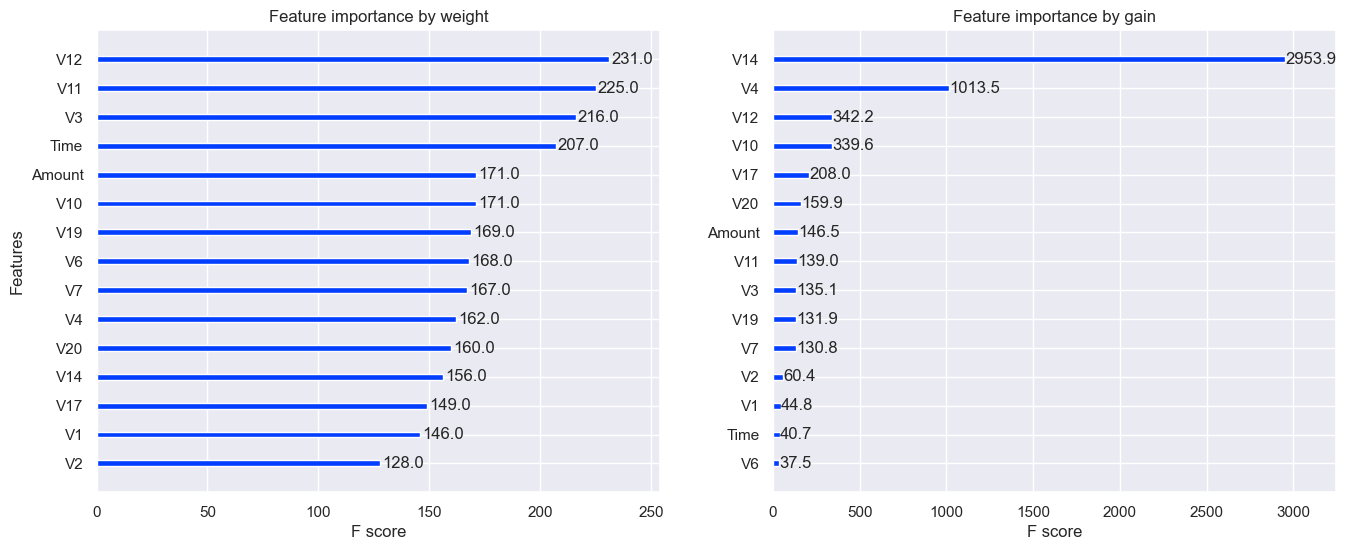

In [68]:
fig, axs = plt.subplots(ncols=2, nrows=1, 
                       figsize=(16, 6))

importance_types = ['weight', 'gain']

for i, ax in zip(importance_types, axs.flatten()):
    plot_importance(
        grid_search.best_estimator_["clf"],
        ax=ax,
        importance_type=i,
        title=f"Feature importance by {i}",
        values_format="{v:.1f}"
    )

ax.set_ylabel('')

plt.show()

Com esse gráfico podemos ver que a variável _``V12``_,  além de aparecer várias vezes, é significativa. Outras como _``V11``_ e _``V3``_parecem ser importantes para o modelo.

De forma oposta, a _``V14``_ aparece menos no modelo, porém é extremamente significativa, uma variável decisora, o que está em linha com o `permutation importance`.

## Conclusão da busca de parâmetros:


In [69]:
grid_search.best_params_

{'clf__colsample_bytree': 0.6,
 'clf__max_depth': 6,
 'clf__reg_alpha': 1,
 'clf__reg_lambda': 2,
 'clf__subsample': 0.8}

1. Interessante que o modelo vencedor apresentou um `max_depth` intermediário, o que pode indicar boa resistência a _overffiting_.

2. Regularização se mostrou importante em todas as combinações de hiperparâmetros, o que pode poderia indicar redundância de informação nas _features_ se não fosse linearmente independentes. Nesse caso, com o grande ganho (_gain_) de `V4` e `V14`, talvez tenhamos uma base que captura bem o padrão da classe principal (fraudulentos) e modelo que conseguiu contornar bem o desbalanço da base com isso.

3. Pouco ou nenhum impacto tivemos na exclusão de _features_ e na otimização de hiperparâmetros. Isso reforça a característica da base, como discutivo em `2.`.

Ainda em tempo, indicado pelos mecanismos de regularização, em especial L1 (alpha), e combinações intermediárias com lambda máximo, acredito que ainda temos espaço para avaliar o early stopping do modelo vencedor e promover discussão pertinente.

## Early Stopping

Early Stopping é última abordagem de tunnig que faremos. Acredito que é sempre pertinente ponderar de forma separada o número de estimadores, pois me parece mais produtivo. Algo como **"tome o melhor modelo e, usando os melhores parâmetros, extraia até a última gota de informação dessa base"**.

In [70]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, 
    random_state=RANDOM_STATE, 
    stratify=y
)

y_train_arr = np.asanyarray(y_train).astype(int).ravel()
scale_pos_weight = np.bincount(y_train_arr)[0] / np.bincount(y_train_arr)[1]

In [71]:
params_filtrados = {k.replace('clf__', ''): v for k, v in grid_search.best_params_.items()}

modelo_promissor = XGBClassifier(
    **params_filtrados,  

    n_estimators=1000,
    learning_rate=0.05,
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
    early_stopping_rounds=20,
    random_state=RANDOM_STATE
)


# Treino com monitoramento
modelo_promissor.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],   
    verbose=100                   
)

[0]	validation_0-logloss:0.64734
[100]	validation_0-logloss:0.01161
[200]	validation_0-logloss:0.00382
[300]	validation_0-logloss:0.00331
[346]	validation_0-logloss:0.00329


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=20,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

Prova real:

In [72]:
# Obter as probabilidades da classe positiva (1)
y_scores = modelo_promissor.predict_proba(X_test)[:, 1]
y_pred = modelo_promissor.predict(X_test)

precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Calcular a área sob a curva (AUPRC)
auprc_score = auc(recall, precision)
avg_precision = average_precision_score(y_test, y_scores)

print(f"Average Precision: {avg_precision:.2f} \n")
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))

Average Precision: 0.81 

Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42221
           1       0.90      0.74      0.81        74

    accuracy                           1.00     42295
   macro avg       0.95      0.87      0.91     42295
weighted avg       1.00      1.00      1.00     42295



Esse parece ser o nosso modelo final com métricas realistas para a base tratada. A baixo vamos fazer um "teste de fogo" com os registros reservados da base original, mas oq fica  de  aprendizado é que o nosso modelo tem **_performance_ real ao redor de 0.8** e é muito bom em encontrar os casos normais, ou seja, Falsos positivos raros.

## Shap Values

Ao invés de trazer novamente o gráfico de feature importances, podemos observar outra forma de entender nosso modelo. Este gráfico, conhecido como ``SHAP Summary Plot``, é uma das ferramentas mais poderosas para entender os modelos de ML. Ele não apenas diz quais variáveis são importantes, mas como elas influenciam a decisão de fraude.

As variáveis estão organizadas de cima para baixo por ordem de importância global. _``V14``_ é a variável que mais impacta o modelo, seguida por _``V4``_ e _``V12``_, como esperávamos a partir da análise de _feature importances_.

A cor representa o valor real da variável naquela transação específica, por exemplo, observe que os **pontos azuis (valores baixos de V14)** estão concentrados no lado **direito**. Isso significa que quanto menor o valor de _``V14``_, maior a chance de ser ``fraude``.

Em _``V4``_ os pontos vermelhos estão à direita. Isso indica que valores altos de _``V4``_ **aumentam** drasticamente a chance de ``fraude``.

_Features_ intermediárias, como ``Amount``, apresentam uma mistura de cores, mas há uma cauda de pontos vermelhos (valores altos) que se estende para a direita, **sugerindo que transações de valor muito alto podem ser um indicador de risco**, embora não tão forte quanto as variáveis latentes (_``V14``_, _``V4``_). O impacto parece ser menor na coluna ``Time`` (até porque temos apenas dois dias de registros, então talvez os horários nos dias selecionados tenham pouco impacto), indicando que o tempo, isoladamente, não é o fator decisivo para o modelo comparado às outras _features_. Logo, essas colunas centralizadas, por elas mesmas, carregam pouca informação para discriminar a classe.


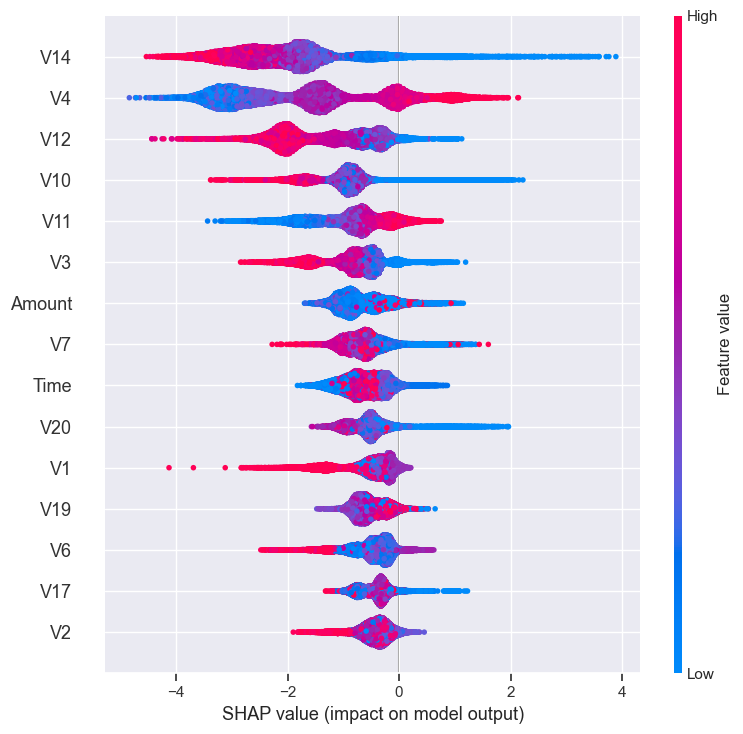

In [73]:
explainer = shap.TreeExplainer(modelo_promissor)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

## Matriz de confusão final

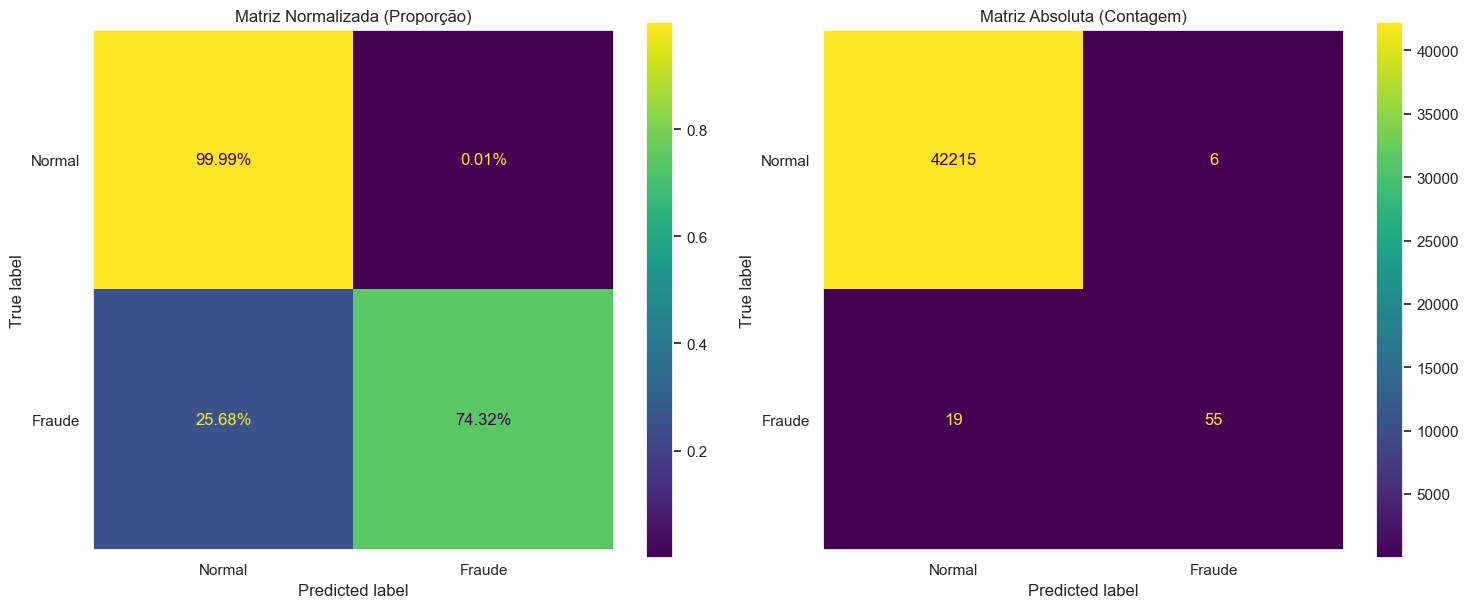

In [74]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(15, 6)) 

normalizes = ["true", None]
titles = ["Matriz Normalizada (Proporção)", "Matriz Absoluta (Contagem)"]

for ax, n, title in zip(axs.flatten(), normalizes, titles):
    
    fmt = ".2%" if n == "true" else "d"
    
    ConfusionMatrixDisplay.from_estimator(
        estimator=modelo_promissor,
        X=X_test,      
        y=y_test,              
        display_labels=["Normal", "Fraude"], 
        normalize=n,
        values_format=fmt,
        ax=ax,
    )
    ax.set_title(title)
    ax.grid(False)

plt.tight_layout()
plt.show()

## Predict Probability

Em um modelo real, é mais confiável associar a classificação com um percentual de probabilidade, pois isso ajuda na tomada de decisões. No nosso caso de estudo, isso pode ajudar aos tomadores de decisão e analistas a aceitarem prontamente o risco de confiar na previsão do modelo (para aqueles casos com probabilidade alta de fraude) OU levarem o caso a um estudo mais detalhado (para aqueles casos com probalidade próxima de 50%).

In [75]:
# Recuperando as probabilidades

# Coluna 0: Probabilidade de ser Normal
# Coluna 1: Probabilidade de ser Fraude

probs = modelo_promissor.predict_proba(X_test)

df_probs = pd.DataFrame({
    'Prob_Normal': probs[:, 0],
    'Prob_Fraude': probs[:, 1],
    'Previsao_Final': modelo_promissor.predict(X_test)
})

In [76]:
# Verificando casos onde o modelo está "em dúvida" (perto de 0.50)
casos_duvidosos = df_probs[
    (df_probs['Prob_Fraude'] > 0.45) & 
    (df_probs['Prob_Fraude'] < 0.55)
    ]
casos_duvidosos = casos_duvidosos.round(
    {'Prob_Normal' : 3,
     'Prob_Fraude': 3}
    )

casos_duvidosos

,Prob_Normal,Prob_Fraude,Previsao_Final
14959,0.546,0.454,0


### Erros por faixa de probabilidade

In [77]:
df_analise = pd.DataFrame(
    {'probabilidade': probs[:, 1], 
     'real': y_test}
     )
df_analise['faixa'] = pd.cut(df_analise['probabilidade'], 
                             bins=np.arange(0, 1.1, 0.1))

analise_faixas = df_analise.groupby('faixa', observed=False)['real'].agg(['mean', 'count'])

No Data Frame ``analise_faixas`` temos a "probabilidade real". Como a sua coluna ``real`` (vinda do ``y_test``) contém 1 para Fraude e 0 para Normal, a média dessa coluna é exatamente a proporção de fraudes naquela faixa.


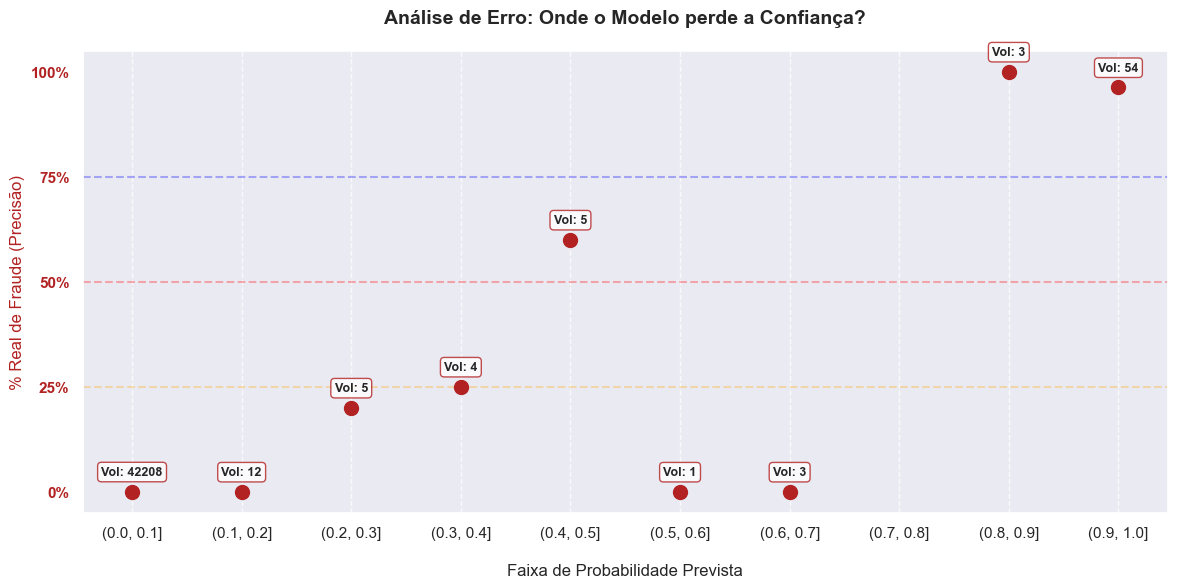

In [78]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.set_ylabel("% Real de Fraude (Precisão)", 
              fontsize=12, color='firebrick')
ax.set_ylim(-0.05, 1.05) 

posicoes = np.arange(0, 1.1, 0.25)
labels_percent = [f'{int(x*100)}%' for x in posicoes]

ax.set_yticks(posicoes)
ax.set_yticklabels(labels_percent, 
                   color='firebrick', fontweight='bold')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0)) 


x_labels = analise_faixas.index.astype(str)
ax.scatter(x_labels, analise_faixas['mean'], 
           color='firebrick', 
           s=100, label='% Real de Fraude', 
           zorder=3)


for i, (index, row) in enumerate(analise_faixas.iterrows()):

    ax.annotate(
        f"Vol: {int(row['count'])}", 
        xy=(i, row['mean']),
        xytext=(0, 12), textcoords="offset points",
        ha='center', fontsize=9, fontweight='bold',
        
        bbox=dict(boxstyle="round,pad=0.3", 
                  fc="white", 
                  ec="firebrick", 
                  alpha=0.8)
    )


for y, color in zip([0.25, 0.5, 0.75], ['orange', 'red', 'blue']):

    ax.axhline(y=y, 
               color=color, linestyle='--', 
               alpha=0.3)

ax.grid(axis='x', linestyle='--', alpha=0.75)
ax.grid(False, axis='y')

ax.set_xlabel("\nFaixa de Probabilidade Prevista", 
              fontsize=12)
ax.set_title("Análise de Erro: Onde o Modelo perde a Confiança?", 
             fontsize=14, fontweight='bold', pad=20)

plt.show()

In [79]:
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-10)

idx_otimo = np.argmax(f1_scores)
threshold_otimo = thresholds[idx_otimo]

print(f"Melhor Threshold: {threshold_otimo:.2f}")
print(f"F1-Score Máximo: {f1_scores[idx_otimo]:.2f}")
print(f"Recall no ponto ótimo: {recall[idx_otimo]:.2f}")
print(f"Precisão no ponto ótimo: {precision[idx_otimo]:.2f}")

Melhor Threshold: 0.42
F1-Score Máximo: 0.84
Recall no ponto ótimo: 0.78
Precisão no ponto ótimo: 0.91


**- Diagnóstico por Faixa de Volume**

Nesse gráfico os pontos vermelhos mostram a ``probabilidade real do registro ser fraude``. Esses valores foram distribuidos no ``eixo x que representa a probabilidade dada pelo modelo`` e acima temos o ``número de casos`` naquela faixa.

O modelo atual mostra uma tendência de crescimento clara (``Progressão Monotônica``). À medida que o modelo aumenta a **probabilidade prevista**, a taxa real de fraude também sobe, o que é o comportamento esperado de um classificador bem calibrado.

Faixas ``acima de 0.8``. podemos **bloquear automaticamente**. 

A chance de erro é quase nula. Entre ``0.4 e 0.8`` é a zona ideal para análise manual. O modelo suspeita com razão, mas ainda **há falsos positivos**.

Abaixo de 0.4, podemos liberar a transação. O **custo de revisar esses casos não compensa**, pois a maioria é ``legítima``.

**Observação:** A "Zona Morta" ou Erro Estátistico (0.5 a 0.7], curiosamente, nesta faixa a precisão cai para 0%. Talvez como o volume é minúsculo (apenas 1 ou 3 transações), qualquer erro aqui joga o ponto para baixo Provavelmente são casos atípicos (_outliers_) que têm características de fraude, mas são legítimos.

Uma **observação importante** para o leitor antento é que o gráfico acima se relaciona com a ``Precisão`` ao invés do ``Recall``!

O gráfico olha apenas para onde o ``modelo atribuiu alguma probabilidade de fraude``. O ``Recall`` de ``~74%`` significa que 26% das fraudes reais receberam uma probabilidade tão baixa (provavelmente entre 0.0 e 0.1) que elas estão escondidas lá no primeiro ponto do gráfico, misturadas com as milhares de transações normais (elas são os ``Falsos Negativos``). Para o modelo, essas 22 transações pareceram tão legítimas que ele não deu nem 10% de probabilidade de fraude para elas.

**Podemos lê-lo da seguinte forma:** "Das vezes que eu previ fraude com **91%** de confiança (0.8 a 1.0), quantas eu acertei?" **O gráfico diz: 100%**. "Porém, de todas as fraudes que aconteceram, quantas eu consegui dar um score alto (score alto = faixas de probabilidade prevista alta)?" O seu Recall de ``78%`` diz que você deixou passar **22 em cada 100 fraudes**.

## Teste com os dados reservados (validação final)

In [80]:
df_teste_reservado = pd.read_parquet(PASTA_DADOS / 'creditcard_TESTE_RESERVADO.parquet')
df_teste_reservado = df_teste_reservado.drop(columns=colunas_filtradas)
df_teste_reservado.shape

(71202, 16)

In [81]:
X_reservado = df_teste_reservado.drop(columns=target)
y_reservado = df_teste_reservado[target]

In [82]:
y_probs_reservado = modelo_promissor.predict_proba(X_reservado)[:, 1]

auprc_reservado = average_precision_score(y_reservado, y_probs_reservado)
precision, recall, _ = precision_recall_curve(y_reservado, y_probs_reservado)
auc_pr = auc(recall, precision)

print(f"--- RESULTADO NO TESTE RESERVADO ---")
print(f"AUPRC (Average Precision): {auprc_reservado:.2f}")

--- RESULTADO NO TESTE RESERVADO ---
AUPRC (Average Precision): 0.68


In [83]:
# Recuperando as probabilidades

# Coluna 0: Probabilidade de ser Normal
# Coluna 1: Probabilidade de ser Fraude

probs = modelo_promissor.predict_proba(X_reservado)

df_probs = pd.DataFrame({
    'Prob_Normal': probs[:, 0],
    'Prob_Fraude': probs[:, 1],
    'Previsao_Final': modelo_promissor.predict(X_reservado)
})

In [84]:
# Verificando casos onde o modelo está "em dúvida" (perto de 0.50)
casos_duvidosos = df_probs[
    (df_probs['Prob_Fraude'] > 0.45) & 
    (df_probs['Prob_Fraude'] < 0.55)
    ]
casos_duvidosos = casos_duvidosos.round(
    {'Prob_Normal' : 3,
     'Prob_Fraude': 3}
    )

casos_duvidosos

,Prob_Normal,Prob_Fraude,Previsao_Final
11051,0.463,0.537,1
24660,0.544,0.456,0
50845,0.485,0.515,1
63965,0.482,0.518,1
66895,0.513,0.487,0
68897,0.540,0.460,0


In [85]:
df_analise = pd.DataFrame(
    {'probabilidade': probs[:, 1], 
     'real': y_reservado.values.ravel()}
     )
df_analise['faixa'] = pd.cut(df_analise['probabilidade'], 
                             bins=np.arange(0, 1.1, 0.1))

analise_faixas = df_analise.groupby('faixa', observed=False)['real'].agg(['mean', 'count'])

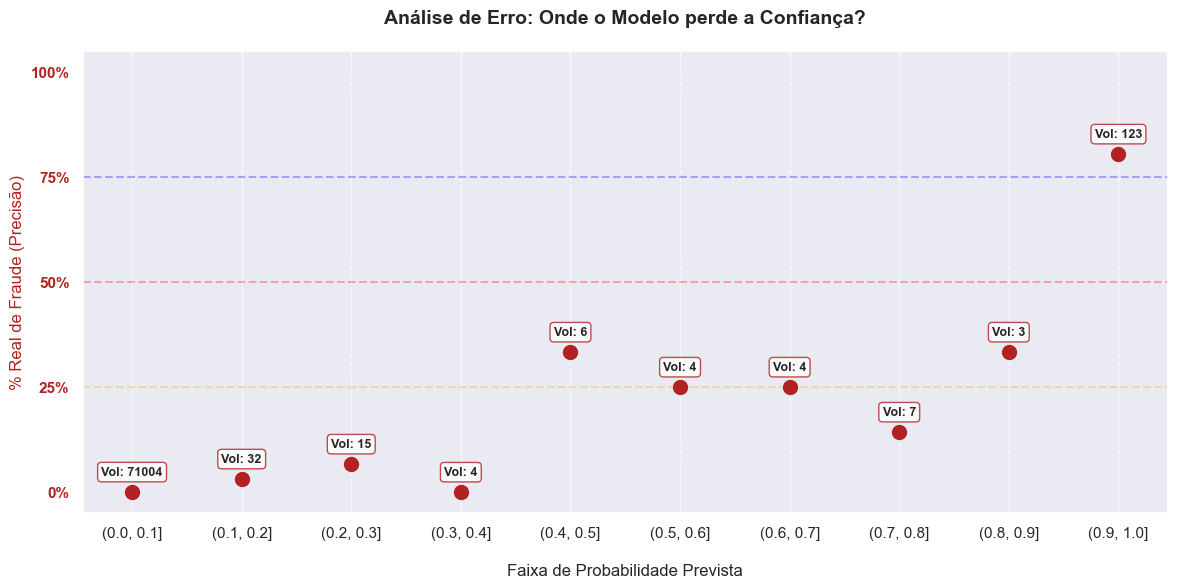

In [86]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.set_ylabel("% Real de Fraude (Precisão)", 
              fontsize=12, color='firebrick')
ax.set_ylim(-0.05, 1.05) 

posicoes = np.arange(0, 1.1, 0.25)
labels_percent = [f'{int(x*100)}%' for x in posicoes]

ax.set_yticks(posicoes)
ax.set_yticklabels(labels_percent, 
                   color='firebrick', fontweight='bold')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0)) 


x_labels = analise_faixas.index.astype(str)
ax.scatter(x_labels, analise_faixas['mean'], 
           color='firebrick', 
           s=100, label='% Real de Fraude', 
           zorder=3)


for i, (index, row) in enumerate(analise_faixas.iterrows()):

    ax.annotate(
        f"Vol: {int(row['count'])}", 
        xy=(i, row['mean']),
        xytext=(0, 12), textcoords="offset points",
        ha='center', fontsize=9, fontweight='bold',
        
        bbox=dict(boxstyle="round,pad=0.3", 
                  fc="white", 
                  ec="firebrick", 
                  alpha=0.8)
    )


for y, color in zip([0.25, 0.5, 0.75], ['orange', 'red', 'blue']):

    ax.axhline(y=y, 
               color=color, linestyle='--', 
               alpha=0.3)

ax.grid(axis='x', linestyle='--', alpha=0.75)
ax.grid(False, axis='y')

ax.set_xlabel("\nFaixa de Probabilidade Prevista", 
              fontsize=12)
ax.set_title("Análise de Erro: Onde o Modelo perde a Confiança?", 
             fontsize=14, fontweight='bold', pad=20)

plt.show()

In [87]:
precision, recall, thresholds = precision_recall_curve(y_reservado, y_probs_reservado)

f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-10)

idx_otimo = np.argmax(f1_scores)
threshold_otimo = thresholds[idx_otimo]

print(f"Melhor Threshold: {threshold_otimo:.2f}")
print(f"F1-Score Máximo: {f1_scores[idx_otimo]:.2f}")
print(f"Recall no ponto ótimo: {recall[idx_otimo]:.2f}")
print(f"Precisão no ponto ótimo: {precision[idx_otimo]:.2f}")

Melhor Threshold: 0.89
F1-Score Máximo: 0.81
Recall no ponto ótimo: 0.81
Precisão no ponto ótimo: 0.81


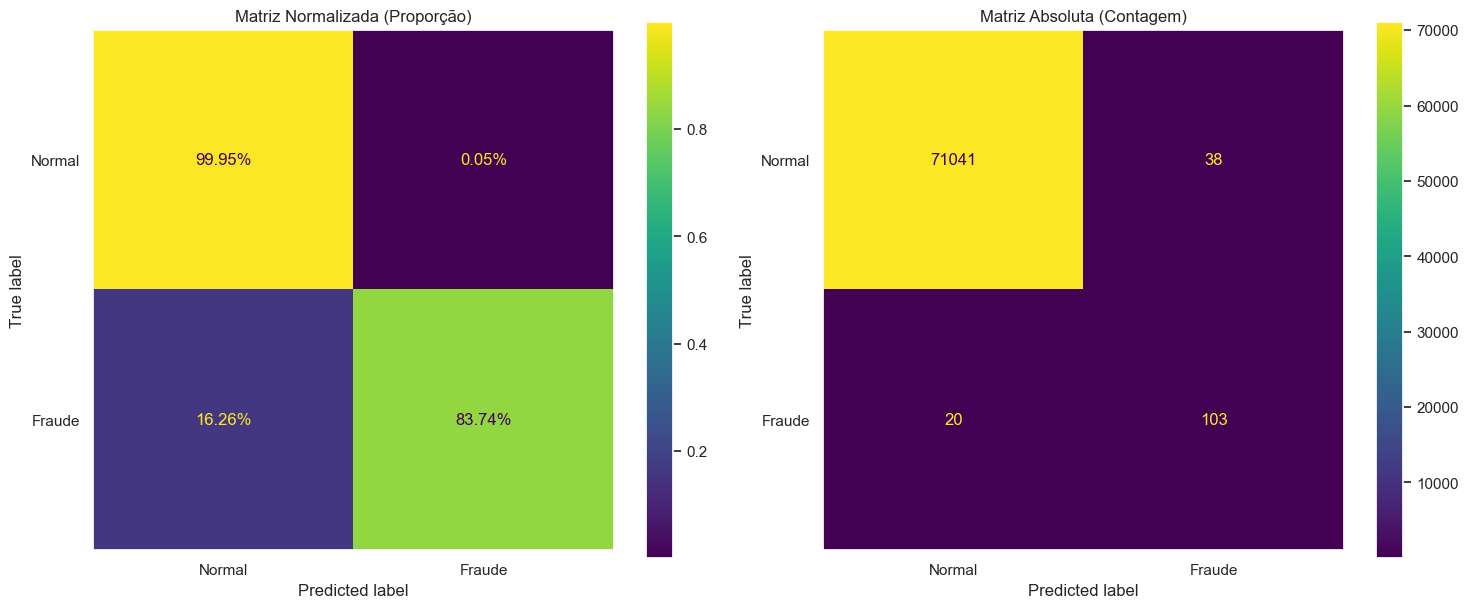

In [88]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(15, 6)) 

normalizes = ["true", None]
titles = ["Matriz Normalizada (Proporção)", "Matriz Absoluta (Contagem)"]

for ax, n, title in zip(axs.flatten(), normalizes, titles):
    
    fmt = ".2%" if n == "true" else "d"
    
    ConfusionMatrixDisplay.from_estimator(
        estimator=modelo_promissor,
        X=X_reservado,      
        y=y_reservado,              
        display_labels=["Normal", "Fraude"], 
        normalize=n,
        values_format=fmt,
        ax=ax,
    )
    ax.set_title(title)
    ax.grid(False)

plt.tight_layout()
plt.show()

**- Conclusão da nova base:**

Os resultados na base reservada (dados inéditos) consolidam o modelo como uma **solução de alta performance e extrema estabilidade para a detecção de fraudes**. Ao comparar com os valores anteriores, observamos um ajuste natural: o Threshold subiu significativamente de ``0,42`` para ``0,89``, indicando que o modelo tornou-se mais **rigoroso para garantir a confiabilidade** em dados novos. Embora o ``F1-Score`` tenha tido uma leve oscilação (de 0,84 para 0,81), a convergência exata de **Recall e Precisão em 0,81** revela um **equilíbrio** estatístico perfeito; o modelo agora entrega uma resposta simétrica, capturando **81% das fraudes existentes com 81% de assertividade nas suas previsões**.

Analisando o novo gráfico de Erro e Confiança da base reservada (última imagem), a validade desse novo limiar de ``0,89`` fica evidente. Note que a maioria esmagadora dos casos (``Vol: 71.004``) está concentrada na **faixa inicial** de probabilidade, onde a taxa de **fraude real é próxima de zero**. O modelo ``mantém sua progressão monotônica``, mas a confiança real (os pontos vermelhos) só dispara verdadeiramente na última casa decimal: na faixa de (0,9, 1,0], onde temos ``123 casos``, a taxa de acerto é altíssima (acima de 80%). Nas faixas intermediárias, o volume de dados é muito baixo (amostras de 3 a 7 casos), o que explica as **flutuações** e a necessidade de um **threshold mais alto para evitar bloqueios indevidos em produção**.

Complementando com o gráfico ``SHAP``, entendemos o porquê dessa segurança: variáveis como _``V14``_, _``V4``_ e _``V12``_ continuam sendo as principais alavancas de decisão. O modelo aprendeu que valores baixos de _``V14``_ (em azul à direita) e valores altos de _``V4``_ (em vermelho à direita) são indicadores críticos que empurram a probabilidade para a zona de bloqueio. Em resumo, a transição para a base reservada provou que o modelo **não está apenas "decorando" o treino**, mas sim aplicando regras de **risco sólidas que permitem operar com segurança em um cenário real**, onde o custo de uma ``fraude`` perdida deve ser equilibrado com a experiência do usuário legítimo.

# Conclusões

**- Sobre modelos:**

1. O ``XGBoost`` é a escolha mais robusta para este cenário de fraude. Ao contrário do ``AdaBoost``, que é "sequestrado" por _outliers_ devido ao seu foco obsessivo em pesos, ou do ``LGBM``, que pode perder generalização em desbalanceamentos extremos, o ``XGBoost`` utiliza gradientes e regularização $L2$ para tratar as anomalias de forma sofisticada. Em termos operacionais, ele provou ser **duas vezes mais rápido que o ``ExtraTrees``** para treinamento e previsão, oferecendo o melhor compromisso entre custo computacional e performance.

2. O modelo demonstrou ser ``extremamente confiável`` tanto na base **limpa** quanto na base **crua**, apresentando uma progressão ``monotônica`` ideal. Isso significa que, à medida que a probabilidade prevista pelo modelo aumenta, **a taxa real de fraude também sobe**, caracterizando um **classificador bem calibrado**. Na base reservada, o modelo atingiu um equilíbrio estatístico simétrico com ``Recall`` e ``Precisão`` convergindo em ``0,81``,indicando que ele não apenas "decorou" os dados de treino, mas **aprendeu padrões de risco sólidos** e aplicáveis ao mundo real.

3. Houve uma redução drástica de complexidade, passando de ``30 features originais para apenas 15`` com impacto mínimo nas métricas de ``AUPRC``. O gráfico ``SHAP`` revela que as variáveis _``V14``_, _``V4``_ e _``V12``_ são as verdadeiras alavancas de decisão: valores baixos de _``V14``_ e altos de __`V4`__ aumentam drasticamente o risco de fraude. Variáveis como _``Amount``_ e _``Time``_ mostraram-se secundárias, confirmando que a inteligência do modelo reside na detecção de padrões latentes e não apenas em valores absolutos ou horários isolados.

4. Existe certa **resistência aos hiperparâmetros** que podemos explicar com os três pontos acima: Em problemas com desbalanceamento severo e _features_ latentes fortes, a engenharia de dados e a seleção de features impactam mais o resultado do que a busca exaustiva por hiperparâmetros. A redução de ``30`` para ``15`` _features_ sem perda de performance (``AUPRC`` constante) é a prova cabal dessa saturação.

**- Sobre a base**

5. A análise comparativa entre **diferentes proporções** de base serviu como um alerta crítico para o _overfitting_. Em bases muito reduzidas ou desbalanceadas artificialmente, os modelos tendem a encontrar "padrões" pouco aderentes à realidade, **perdendo a capacidade de generalização**. A oscilação nas métricas durante a validação cruzada em amostras pequenas **reforçou que qualquer erro de amostragem pode distorcer a confiança do modelo**, exigindo cautela na interpretação de melhorias "milagrosas" em subsets menores.

6. A análise comparativa entre as técnicas de balanceamento e o desempenho na base reservada ("cofre") revela uma lição fundamental sobre ciência de dados aplicada a fraudes: **nem todo balanceamento que melhora o treino sobrevive à realidade**. Para este _dataset_, estratégias **que preservam a distribuição original** (como scale_pos_weight ou BalancedBagging) tendem a ser mais resilientes do que estratégias que tentam "consertar" o desbalanceamento através de simulação.

**- Sobre o negócio**

7. O diagnóstico por faixa de volume definiu a estratégia de negócio: o **``threshold`` ótimo de ``0,89``** na base reservada garante que **bloqueios automáticos acima de ``0,80``** tenham chance de erro quase nula. O modelo é **excelente em identificar o que é legítimo** (concentrando 71.004 casos na faixa de probabilidade zero), mas admite um limite físico nos dados: o Recall de ``~80%`` indica que cerca de **20% das fraudes** são tão parecidas com transações normais que recebem scores baixíssimos, tornando-se "invisíveis" (Falsos Negativos) sem a adição de novas camadas de informação. Logo, a faixa ``0,4 e 0,89`` deve ser considerada com atenção pela equipe de análise, pois é a zona obscura do modelo.
